# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


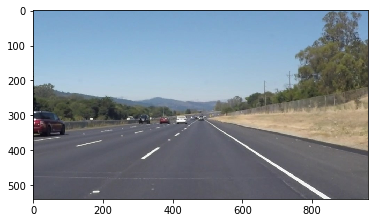

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lane_lines(line_img, lines)
#     draw_lines(line_img, lines)
    draw_lane_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def lanes_average(lines):
    """
    `lines` should be the list of lines from the `hough_lines` function
    Calculates the average slope and intercept for the left_lane and right_lane
    """
    left_lane_lines = []
    right_lane_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            if slope < 0:
                left_lane_lines.append((slope, intercept))
            else:
                right_lane_lines.append((slope, intercept))
    left_lane = tuple(np.average(left_lane_lines, axis=0)) if len(left_lane_lines) > 0 else None
    right_lane = tuple(np.average(right_lane_lines, axis=0)) if len(right_lane_lines) > 0 else None
    
    return left_lane, right_lane


def line_points(line_params, y1, y2):
    """
    `line_params` is a tuple with the slope and intercept to calculate the points
    `y1` and `y2` are the coordinates in y for the two points. Basically delimites the region of interest
    Calculates the points that describe the line given a tuple with the slope and intercept
    """
    slope, intercept = line_params
    x1 = (y1 - intercept) / slope
    x1 = int(x1) if np.isfinite(x1) else None
    x2 = (y2 - intercept) / slope
    x2 = int(x2) if np.isfinite(x2) else None
    y1 = int(y1) if np.isfinite(y1) else None
    y2 = int(y2) if np.isfinite(y2) else None
    return (x1, y1, x2, y2)


def lane_points(image, lines):
    """
    Returns the coords x,y for each of the two lines of the lanes needed to draw on the original image
    """
    y1 = image.shape[0]
    y2 = image.shape[0] * 0.6
    left_line_params, right_line_params = lanes_average(lines)
    if left_line_params is not None and right_line_params is not None:
        left_lane_points = line_points(left_line_params, y1, y2)
        right_lane_points = line_points(right_line_params, y1, y2)
        return left_lane_points, right_lane_points
    return None
    

def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=10):
    """
    Draw the two solid lines across the region of interest
    """
    points = lane_points(image, lines)
    if points is not None:
        for line in points:
            if None not in line:
                x1, y1, x2, y2 = line
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)    
 

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

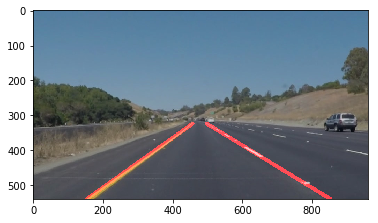

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
image = mpimg.imread('test_images/solidYellowCurve.jpg')
imshape = image.shape[0:2]
height, width = imshape
# gaussian parrams
kernel_size = 5
# Canny params
low_threshold = 50
high_threshold = 150
# Hough params
rho = 1
theta = np.pi/180
threshold = 20
min_line_len = 30
max_line_gap = 10
# - image to gray scale
gray = grayscale(image)
# -Apply gaussian filter
blur_gray = gaussian_blur(gray, kernel_size)
# -Canny edge detection
edges = canny(blur_gray, low_threshold, high_threshold)
# -masked edges
bottom_left = (width * 0.1, height)
top_left = (width * 0.4, height * 0.6)
top_right = (width * 0.6, height * 0.6)
bottom_right = (width * 0.95, height)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
# -Hough lines
image_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
img_weighted = weighted_img(image_lines, image)
plt.imshow(img_weighted)
plt.imsave('examples/img_weighted.png', img_weighted)
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape = image.shape[0:2]
    height, width = imshape
    # gaussian parrams
    kernel_size = 5
    # Canny params
    low_threshold = 50
    high_threshold = 150
    # Hough params
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 30
    max_line_gap = 10
    # - image to gray scale
    gray = grayscale(image)
    # -Apply gaussian filter
    blur_gray = gaussian_blur(gray, kernel_size)
    # -Canny edge detection
    edges = canny(blur_gray, low_threshold, high_threshold)
    # -masked edges
    bottom_left = (width * 0.1, height)
    top_left = (width * 0.4, height * 0.6)
    top_right = (width * 0.6, height * 0.6)
    bottom_right = (width * 0.95, height)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # -Hough lines
    image_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(image_lines, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [26]:
# white_output = 'test_videos_output/solidYellowLeft.mp4'
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,10)
# clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 250/251 [00:06<00:00, 38.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 3.37 s, sys: 1.23 s, total: 4.59 s
Wall time: 7.27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [57]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.6161193449029042 608.518586360248
0.6729703528365214 -19.27289973696385
-0.6161193449029042 608.518586360248
0.6729703528365214 -19.27289973696385
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4









  0%|          | 0/682 [00:00<?, ?it/s]






  1%|          | 6/682 [00:00<00:11, 56.56it/s]

-0.6161193449029042 608.518586360248
0.6729703528365214 -19.27289973696385
-0.6161193449029042 608.518586360248
0.6729703528365214 -19.27289973696385
-0.6161018461215333 610.2790579843356
0.6775248074672042 -22.73763562249941
-0.6161018461215333 610.2790579843356
0.6775248074672042 -22.73763562249941
-0.6254529487009646 612.4740701796645
0.6612008824655609 -11.451387484305304
-0.6254529487009646 612.4740701796645
0.6612008824655609 -11.451387484305304
-0.6315013584215832 614.6233083353096
0.6804713804713804 -23.464646464646496
-0.6315013584215832 614.6233083353096
0.6804713804713804 -23.464646464646496
-0.6405294694401764 620.3165682058955
0.6677410994484165 -16.979169976730958
-0.6405294694401764 620.3165682058955
0.6677410994484165 -16.979169976730958
-0.6554213807239927 628.4795704272134
0.6458333333333333 -5.875
-0.6554213807239927 628.4795704272134
0.6458333333333333 -5.875
-0.643939381338333 622.6611582811663
0.673704481792717 -22.53389355742297
-0.643939381338333 622.66115828116








  2%|▏         | 12/682 [00:00<00:11, 56.58it/s]

-0.6629725445734543 627.1467872258777
0.6640145544346364 -19.609619325346785
-0.6629725445734543 627.1467872258777
0.6640145544346364 -19.609619325346785
-0.6587874154130764 626.2851461459205
0.6454107814867308 -7.549162634605651
-0.6587874154130764 626.2851461459205
0.6454107814867308 -7.549162634605651









  3%|▎         | 18/682 [00:00<00:11, 56.50it/s]

-0.6671353052096723 630.8178095193445
0.647287784679089 -9.531221532091095
-0.6671353052096723 630.8178095193445
0.647287784679089 -9.531221532091095
-0.6585581212783701 627.7812755356359
0.6364931809587092 -1.2049362332094802
-0.6585581212783701 627.7812755356359
0.6364931809587092 -1.2049362332094802
-0.6850253803165182 639.3548384361134
0.6443703703703704 -7.334037037037047
-0.6850253803165182 639.3548384361134
0.6443703703703704 -7.334037037037047
-0.6794382296973679 636.8815188869515
0.6389300537264787 -3.346029078501772
-0.6794382296973679 636.8815188869515
0.6389300537264787 -3.346029078501772
-0.6823546453541041 638.1330823659342
0.6190251280692458 10.261603294470934
-0.6823546453541041 638.1330823659342
0.6190251280692458 10.261603294470934
-0.6873201198036872 639.1656299787209
0.65625 -13.15625
-0.6873201198036872 639.1656299787209
0.65625 -13.15625
-0.6843418526161696 642.4922746299375
0.6285714285714286 1.7571428571428669
-0.6843418526161696 642.4922746299375
0.628571428571








  4%|▎         | 24/682 [00:00<00:11, 57.35it/s]

-0.6850023171978167 634.964395781757
0.6254058165747917 3.028139932933456
-0.6850023171978167 634.964395781757
0.6254058165747917 3.028139932933456
-0.684643246121545 635.6879694788853
0.6262186443693293 0.7462729051770225
-0.684643246121545 635.6879694788853
0.6262186443693293 0.7462729051770225









  4%|▍         | 30/682 [00:00<00:11, 55.85it/s]

-0.6806569897899925 634.5259590974239
0.6327503335298862 -1.7368618022422169
-0.6806569897899925 634.5259590974239
0.6327503335298862 -1.7368618022422169
-0.7134723803548981 651.1931444978842
0.610617592572282 14.976161644403257
-0.7134723803548981 651.1931444978842
0.610617592572282 14.976161644403257
-0.7169231410854346 651.752548085082
0.6353427286452463 -3.3005611138282234
-0.7169231410854346 651.752548085082
0.6353427286452463 -3.3005611138282234
-0.7015759730063577 644.8435889767483
0.6153917361642319 9.061808553642186
-0.7015759730063577 644.8435889767483
0.6153917361642319 9.061808553642186
-0.7028134337448322 645.3669465101441
0.6015330674180004 17.510138936666294
-0.7028134337448322 645.3669465101441
0.6015330674180004 17.510138936666294
-0.7087266908825011 646.6234135321616
0.6218350754936122 -0.6078977932636604
-0.7087266908825011 646.6234135321616
0.6218350754936122 -0.6078977932636604
-0.7281383085558544 654.3791227346824
0.6 17.400000000000034
-0.7281383085558544 654.379








  5%|▌         | 37/682 [00:00<00:11, 58.14it/s]

-0.6672712979305272 647.6566245071697
0.5931179931179931 18.603130203130206
-0.6672712979305272 647.6566245071697
0.5931179931179931 18.603130203130206
-0.7245301261909775 654.1533924463733
0.610521716155519 8.096940227221907
-0.7245301261909775 654.1533924463733
0.610521716155519 8.096940227221907
-0.7417558250424975 658.1865645329389
0.6035039391761834 13.60261078598619
-0.7417558250424975 658.1865645329389
0.6035039391761834 13.60261078598619









  7%|▋         | 45/682 [00:00<00:10, 61.49it/s]

-0.7468709215649112 658.0784097630658
0.6077460830667964 9.845331838409123
-0.7468709215649112 658.0784097630658
0.6077460830667964 9.845331838409123
-0.7446117651327765 658.5423942544977
0.5974919618109916 17.11914165333009
-0.7446117651327765 658.5423942544977
0.5974919618109916 17.11914165333009
-0.7331695037115781 652.6034393719827
0.6078748554432766 7.117325248009445
-0.7331695037115781 652.6034393719827
0.6078748554432766 7.117325248009445
-0.7385501084702081 654.7791295490297
0.5988035279235382 15.387124016116928
-0.7385501084702081 654.7791295490297
0.5988035279235382 15.387124016116928
-0.7362587777422609 654.1277966182847
0.6024579146432849 14.19083226632523
-0.7362587777422609 654.1277966182847
0.6024579146432849 14.19083226632523
-0.724804380905348 649.5519270522212
0.625 2.875
-0.724804380905348 649.5519270522212
0.625 2.875
-0.6420800240438923 633.0178662793847
0.6136363636363636 10.909090909090878
-0.6420800240438923 633.0178662793847
0.6136363636363636 10.90909090909087








  7%|▋         | 51/682 [00:00<00:14, 42.71it/s]

-0.7249844393598057 650.2823460318905
0.6165385077496095 6.589550042052139
-0.7249844393598057 650.2823460318905
0.6165385077496095 6.589550042052139
-0.727915908672958 650.6698666571466
0.6099837384647511 10.669706892491732
-0.727915908672958 650.6698666571466
0.6099837384647511 10.669706892491732
-0.7394173464917057 654.2589442148015
0.5965131182771133 18.540532552695367
-0.7394173464917057 654.2589442148015
0.5965131182771133 18.540532552695367
-0.7334527343016631 650.7369261451868
0.6140230351791695 6.244655920273971
-0.7334527343016631 650.7369261451868
0.6140230351791695 6.244655920273971
-0.7242554860934909 648.8821889508237
0.597580274586719 18.235841972541323
-0.7242554860934909 648.8821889508237
0.597580274586719 18.235841972541323
-0.7283794657994873 650.5489631527897
0.6122130190783068 9.462134368290265
-0.7283794657994873 650.5489631527897
0.6122130190783068 9.462134368290265
-0.7350059044118021 653.9867597391966
0.5974516091135752 20.89740255798928
-0.7350059044118021 653








  8%|▊         | 57/682 [00:01<00:15, 40.01it/s]






  9%|▉         | 62/682 [00:01<00:16, 37.57it/s]

-0.7342321189690704 653.6458783884708
0.6223332576273752 6.406435006435022
-0.7342321189690704 653.6458783884708
0.6223332576273752 6.406435006435022
-0.7275278720411796 650.1934676093705
0.5894660894660895 25.26695526695526
-0.7275278720411796 650.1934676093705
0.5894660894660895 25.26695526695526
-0.7137681521965087 645.8581266445352
0.598637568234841 20.602709008131555
-0.7137681521965087 645.8581266445352
0.598637568234841 20.602709008131555
-0.7157957148102663 646.2674238573292
0.6064089032742284 16.421923960971938
-0.7157957148102663 646.2674238573292
0.6064089032742284 16.421923960971938
-0.6931430659964464 636.3925808298297
0.6374479991553162 -4.967940027452229
-0.6931430659964464 636.3925808298297
0.6374479991553162 -4.967940027452229
-0.6988880068669407 638.7100431230003
0.6132368490615914 12.455987311657415
-0.6988880068669407 638.7100431230003
0.6132368490615914 12.455987311657415
-0.6979313657287992 638.2393557234024
0.603485749457443 18.44344698473357
-0.6979313657287992 








 10%|▉         | 67/682 [00:01<00:16, 36.36it/s]






 10%|█         | 71/682 [00:01<00:18, 33.25it/s]

-0.7098691414956595 642.6057055537873
0.6107022200772201 13.723929902809203
-0.7098691414956595 642.6057055537873
0.6107022200772201 13.723929902809203
-0.6875268311115985 635.609128401945
0.591755021612001 29.604769260106778
-0.6875268311115985 635.609128401945
0.591755021612001 29.604769260106778
-0.7086213898912026 642.9732538279134
0.6 23.80000000000001
-0.7086213898912026 642.9732538279134
0.6 23.80000000000001
-0.7027366677823864 642.652063845465
0.582051282051282 32.19743589743592
-0.7027366677823864 642.652063845465
0.582051282051282 32.19743589743592
-0.6996605011541324 640.676327537193
0.6145604395604396 12.245604395604389
-0.6996605011541324 640.676327537193
0.6145604395604396 12.245604395604389









 11%|█         | 75/682 [00:01<00:17, 35.00it/s]

-0.7049730570647931 643.3707430348921
0.6020147531112003 20.696472300281016
-0.7049730570647931 643.3707430348921
0.6020147531112003 20.696472300281016
-0.7095532929577982 645.6117148420086
0.5995978722467075 21.749670291516697
-0.7095532929577982 645.6117148420086
0.5995978722467075 21.749670291516697
-0.7002378427089962 641.531826206911
0.6001830107994492 22.180512067840823
-0.7002378427089962 641.531826206911
0.6001830107994492 22.180512067840823
-0.7048883868750269 641.7894845349684
0.6100976321158653 17.555159271818155
-0.7048883868750269 641.7894845349684
0.6100976321158653 17.555159271818155
-0.7056201267344643 642.6568952327214
0.6254677474178851 7.404011521122058
-0.7056201267344643 642.6568952327214
0.6254677474178851 7.404011521122058
-0.7028297198027437 643.0824142649648
0.6089901405356078 18.793584204858725
-0.7028297198027437 643.0824142649648
0.6089901405356078 18.793584204858725
-0.708529758341854 643.8029405857691
0.6136657078146439 16.385962323728293
-0.70852975834185








 12%|█▏        | 79/682 [00:01<00:19, 31.65it/s]






 12%|█▏        | 83/682 [00:01<00:18, 33.21it/s]

-0.6952701210559781 641.3838783790933
0.6092336973858871 20.205276880603066
-0.6952701210559781 641.3838783790933
0.6092336973858871 20.205276880603066
-0.6927840393515781 639.3035503772956
0.6351109273804602 0.9926967066280857
-0.6927840393515781 639.3035503772956
0.6351109273804602 0.9926967066280857
-0.7072530122167972 641.1907937557082
0.6666666666666666 -16.0
-0.7072530122167972 641.1907937557082
0.6666666666666666 -16.0
-0.6952888198260857 637.8755528318653
0.6366541353383459 -1.830827067669162
-0.6952888198260857 637.8755528318653
0.6366541353383459 -1.830827067669162
-0.6961675998818856 638.0848004325146
0.6114708603145237 14.352759790317597
-0.6961675998818856 638.0848004325146
0.6114708603145237 14.352759790317597
-0.7000846612301103 639.3976220136013
0.628917378917379 4.991809116809108
-0.7000846612301103 639.3976220136013
0.628917378917379 4.991809116809108









 13%|█▎        | 87/682 [00:02<00:18, 32.25it/s]






 13%|█▎        | 91/682 [00:02<00:19, 30.31it/s]

-0.7014139379260022 639.9367355029947
0.6313706037970744 5.102795284780598
-0.7014139379260022 639.9367355029947
0.6313706037970744 5.102795284780598
-0.6934454840944365 638.2060182156598
0.6339237164282372 1.4320078655521655
-0.6934454840944365 638.2060182156598
0.6339237164282372 1.4320078655521655
-0.6873921740549146 634.466093403262
0.6398694690385931 -1.7785337088540814
-0.6873921740549146 634.466093403262
0.6398694690385931 -1.7785337088540814
-0.6861577962451824 633.8035123843138
0.6388479196716913 -1.4772445297996228
-0.6861577962451824 633.8035123843138
0.6388479196716913 -1.4772445297996228
-0.684977896121767 634.1057043220488
0.6173716385289151 13.514515059726786
-0.684977896121767 634.1057043220488
0.6173716385289151 13.514515059726786
-0.684327404674567 635.0627535442208
0.6189941950120308 12.38230670712079
-0.684327404674567 635.0627535442208
0.6189941950120308 12.38230670712079









 14%|█▍        | 95/682 [00:02<00:18, 31.10it/s]

-0.6893969079231665 636.2890659214302
0.624379581780752 11.108363113785913
-0.6893969079231665 636.2890659214302
0.624379581780752 11.108363113785913
-0.6846179153828665 636.47460858266
0.636164274322169 2.7170255183413303
-0.6846179153828665 636.47460858266
0.636164274322169 2.7170255183413303
-0.6890191785374835 640.3145871963955
0.6376344086021505 4.102508960573478
-0.6890191785374835 640.3145871963955
0.6376344086021505 4.102508960573478
-0.7045508982309779 645.7004936731333
0.6361066949302243 5.224695283518808
-0.7045508982309779 645.7004936731333
0.6361066949302243 5.224695283518808
-0.6892310461845678 638.503278444866
0.6301692009540847 7.325078264758503
-0.6892310461845678 638.503278444866
0.6301692009540847 7.325078264758503
-0.6974426185000667 642.7609423804532
0.6428254562273988 -0.8381033975275471
-0.6974426185000667 642.7609423804532
0.6428254562273988 -0.8381033975275471
-0.6921712476855363 640.7269018490323
0.6233716475095785 10.0360153256705
-0.6921712476855363 640.7269








 15%|█▍        | 99/682 [00:02<00:18, 31.93it/s]






 15%|█▌        | 103/682 [00:02<00:18, 30.50it/s]

-0.7005807899820048 644.8695997952716
0.6537353577794753 -9.177290234275517
-0.7005807899820048 644.8695997952716
0.6537353577794753 -9.177290234275517
-0.6949158270352706 641.8567937471623
0.6422175724599624 -0.9264295287914251
-0.6949158270352706 641.8567937471623
0.6422175724599624 -0.9264295287914251
-0.6885022145179858 640.2875192943424
0.6309094965794464 6.052965049535956
-0.6885022145179858 640.2875192943424
0.6309094965794464 6.052965049535956
-0.6879988583863792 637.9842063022185
0.6226639469254056 11.789693268715391
-0.6879988583863792 637.9842063022185
0.6226639469254056 11.789693268715391
-0.68920059357659 638.6351823438755
0.6271693654531382 9.224087234271877
-0.68920059357659 638.6351823438755
0.6271693654531382 9.224087234271877
-0.6863674079201398 636.1600508975242
0.6212332910196696 12.124781803095562
-0.6863674079201398 636.1600508975242
0.6212332910196696 12.124781803095562









 16%|█▌        | 107/682 [00:02<00:17, 32.14it/s]






 16%|█▋        | 111/682 [00:02<00:18, 31.42it/s]

-0.7018996689261727 643.3596397168228
0.6295777568062229 7.229302505147558
-0.7018996689261727 643.3596397168228
0.6295777568062229 7.229302505147558
-0.683549705950625 636.0107577528719
0.6256109481915934 8.0
-0.683549705950625 636.0107577528719
0.6256109481915934 8.0
-0.6888895783641013 638.8262840189813
0.6098087098087098 17.54676434676433
-0.6888895783641013 638.8262840189813
0.6098087098087098 17.54676434676433
-0.6935566507250457 639.6639220731842
0.6169781438074121 14.483227747861875
-0.6935566507250457 639.6639220731842
0.6169781438074121 14.483227747861875
-0.6918117067535173 640.6002058234352
0.6203002817288532 12.81854462997319
-0.6918117067535173 640.6002058234352
0.6203002817288532 12.81854462997319
-0.6886349960024495 640.5418311698836
0.6415570175438596 -1.2148026315789622
-0.6886349960024495 640.5418311698836
0.6415570175438596 -1.2148026315789622









 17%|█▋        | 115/682 [00:03<00:18, 31.41it/s]

-0.6865978606629909 639.2712811069229
0.6216649123106944 11.834115059701006
-0.6865978606629909 639.2712811069229
0.6216649123106944 11.834115059701006
-0.6925339517771529 641.3808699940112
0.6195032515789675 12.45216753143178
-0.6925339517771529 641.3808699940112
0.6195032515789675 12.45216753143178
-0.6919792665692347 641.1416217103846
0.6326861370141956 3.29288603854026
-0.6919792665692347 641.1416217103846
0.6326861370141956 3.29288603854026
-0.6920727560189959 640.6768267690619
0.6313829591219822 3.83146482998607
-0.6920727560189959 640.6768267690619
0.6313829591219822 3.83146482998607
-0.6902965477680522 640.2049832478016
0.6189900468384075 12.436835480093668
-0.6902965477680522 640.2049832478016
0.6189900468384075 12.436835480093668
-0.6883698055424319 638.9371181807921
0.622377884951156 9.938432795789264
-0.6883698055424319 638.9371181807921
0.622377884951156 9.938432795789264
-0.6904836499900974 








 17%|█▋        | 119/682 [00:03<00:18, 29.89it/s]






 18%|█▊        | 123/682 [00:03<00:18, 30.58it/s]

640.7279573475791
0.5941176470588235 27.558823529411768
-0.6904836499900974 640.7279573475791
0.5941176470588235 27.558823529411768
-0.6955962754940809 640.9666412689213
0.6131313131313131 13.446464646464676
-0.6955962754940809 640.9666412689213
0.6131313131313131 13.446464646464676
-0.7027158316378409 644.239116860201
0.6196115288220551 11.529511278195494
-0.7027158316378409 644.239116860201
0.6196115288220551 11.529511278195494
-0.7003889640537656 644.0474027620539
0.6580357142857143 -14.753571428571453
-0.7003889640537656 644.0474027620539
0.6580357142857143 -14.753571428571453
-0.7024669620611604 644.9137893445592
0.6274566207601922 5.898098181580309
-0.7024669620611604 644.9137893445592
0.6274566207601922 5.898098181580309
-0.7120625147434703 647.7707099473723
0.6226398760707126 9.583529250956815
-0.7120625147434703 647.7707099473723
0.6226398760707126 9.583529250956815
-0.7055799061737208 645.5208812104984
0.6330710949413445 2.0739584308922474
-0.7055799061737208








 19%|█▊        | 127/682 [00:03<00:18, 30.82it/s]








 645.5208812104984
0.6330710949413445 2.0739584308922474
-0.7050839696697915 644.5039631439623
0.6353738666111891 2.1804406997104593
-0.7050839696697915 644.5039631439623
0.6353738666111891 2.1804406997104593
-0.7092596533080487 647.1364554536356
0.6327087242406878 2.8426454799562038
-0.7092596533080487 647.1364554536356
0.6327087242406878 2.8426454799562038
-0.7043800824896086 647.0956800790138
0.6198177627666522 12.343918798677029
-0.7043800824896086 647.0956800790138
0.6198177627666522 12.343918798677029
-0.7007974095632449 645.6064898681472
0.6120295698924731 18.29133064516128
-0.7007974095632449 645.6064898681472
0.6120295698924731 18.29133064516128
-0.6991022318071528 644.6035912747319
0.614277079303675 16.372848162475833
-0.6991022318071528 644.6035912747319
0.614277079303675 16.372848162475833
-0.6962603091222374 643.539748744341
0.6271317829457365 8.51111111111114
-0.6962603091222374 643.539748744341
0.6271317829457365 8.51111111111114


 19%|█▉        | 131/682 [00:03<00:18, 30.12it/s]






 20%|█▉        | 135/682 [00:03<00:17, 31.61it/s]








-0.7002210927810713 645.559436592573
0.6407624633431085 -2.730205278592365
-0.7002210927810713 645.559436592573
0.6407624633431085 -2.730205278592365
-0.7032762646024249 647.4473757324383
0.645224171539961 -4.384502923976584
-0.7032762646024249 647.4473757324383
0.645224171539961 -4.384502923976584
-0.6941806359666025 643.2664802394058
0.6077974870657797 17.022062084257225
-0.6941806359666025 643.2664802394058
0.6077974870657797 17.022062084257225
-0.6961295660259986 644.151778416773
0.6428401549298965 -3.5662132777639357
-0.6961295660259986 644.151778416773
0.6428401549298965 -3.5662132777639357
-0.6965766040496012 644.6367680442547
0.606432174551598 21.111990503205305
-0.6965766040496012 644.6367680442547
0.606432174551598 21.111990503205305
-0.6976621864899937 644.7316970725243
0.6354351884779517 0.7025915718349722
-0.6976621864899937 644.7316970725243
0.6354351884779517 0.7025915718349722
-0.6921268784153005 641.8192332650274
0.6326952941081024 2.4619527652203126
-0.692126878415300

 20%|██        | 139/682 [00:03<00:17, 30.41it/s]






 21%|██        | 143/682 [00:03<00:17, 31.19it/s]






 22%|██▏       | 147/682 [00:04<00:16, 32.19it/s]

-0.696289209251816 643.0496128164478
0.6137755102040816 16.478061224489792
-0.696289209251816 643.0496128164478
0.6137755102040816 16.478061224489792
-0.6972150329610376 643.4744744401404
0.617735750765339 11.104993712690979
-0.6972150329610376 643.4744744401404
0.617735750765339 11.104993712690979
-0.692542674215115 641.7280284856688
0.613095058536235 17.493137434460962
-0.692542674215115 641.7280284856688
0.613095058536235 17.493137434460962
-0.6912065018346322 641.0206813641142
0.6366749141990582 -2.1380467315826905
-0.6912065018346322 641.0206813641142
0.6366749141990582 -2.1380467315826905
-0.6836279478215824 638.3861590008615
0.6129032258064516 12.935483870967744
-0.6836279478215824 638.3861590008615
0.6129032258064516 12.935483870967744
-0.6968906605296047 644.2985976646394
0.6303763440860215 4.498655913978496
-0.6968906605296047 644.2985976646394
0.6303763440860215 4.498655913978496
-0.692322657227007 641.3531228536011
0.620557804768331 9.268106162842969
-0.692322657227007 641.








 22%|██▏       | 151/682 [00:04<00:16, 32.17it/s]

-0.6879207718983157 639.2481860591749
0.6265870171926072 6.520290329063599
-0.6879207718983157 639.2481860591749
0.6265870171926072 6.520290329063599
-0.6983956617104116 644.7159606824927
0.6305894041670319 4.78350720317934
-0.6983956617104116 644.7159606824927
0.6305894041670319 4.78350720317934
-0.6976255968717178 643.9434946807604
0.6170536207849641 11.100193477059142
-0.6976255968717178 643.9434946807604
0.6170536207849641 11.100193477059142
-0.7093419302577059 649.9885755254854
0.6092564123927656 17.32893494743315
-0.7093419302577059 649.9885755254854
0.6092564123927656 17.32893494743315
-0.7024137994932177 647.5253694694098
0.6105525522451942 17.50527662504419
-0.7024137994932177 647.5253694694098
0.6105525522451942 17.50527662504419
-0.6986021664781122 645.2296603040418
0.6105495785425373 16.975346150964185
-0.6986021664781122 645.2296603040418
0.6105495785425373 16.975346150964185









 23%|██▎       | 155/682 [00:04<00:17, 29.76it/s]






 23%|██▎       | 159/682 [00:04<00:17, 30.55it/s]

-0.702764111699533 648.7582581352351
0.5917505944725433 29.90931241226132
-0.702764111699533 648.7582581352351
0.5917505944725433 29.90931241226132
-0.7054364749949545 648.0497407249059
0.6023242630385488 20.5641156462585
-0.7054364749949545 648.0497407249059
0.6023242630385488 20.5641156462585
-0.708375948569666 652.9170776077563
0.6212006079027356 10.705293819655518
-0.708375948569666 652.9170776077563
0.6212006079027356 10.705293819655518
-0.7162170417047519 657.7795854306631
0.5848856209150327 33.11339869281047
-0.7162170417047519 657.7795854306631
0.5848856209150327 33.11339869281047
-0.6933699238546011 649.1491960010279
0.5934922777028041 28.403508771929808
-0.6933699238546011 649.1491960010279
0.5934922777028041 28.403508771929808
-0.702314000629383 652.5998523619756
0.6002699745906268 23.393218873517768
-0.702314000629383 652.5998523619756
0.6002699745906268 23.393218873517768









 24%|██▍       | 163/682 [00:04<00:16, 31.99it/s]

-0.710090272840578 657.1638843830509
0.593127699422849 28.794327867599293
-0.710090272840578 657.1638843830509
0.593127699422849 28.794327867599293
-0.7098199813513459 657.7712140274539
0.5911539968652038 28.571218652037615
-0.7098199813513459 657.7712140274539
0.5911539968652038 28.571218652037615
-0.7081115449044915 653.8364136786462
0.5784564813717356 36.63444605112403
-0.7081115449044915 653.8364136786462
0.5784564813717356 36.63444605112403
-0.7173891954807888 657.929145266924
0.5834108418825595 33.12722745598978
-0.7173891954807888 657.929145266924
0.5834108418825595 33.12722745598978
-0.715097515433756 659.0282541751235
0.5911764705882353 28.558823529411786
-0.715097515433756 659.0282541751235
0.5911764705882353 28.558823529411786
-0.7155485644133021 656.535875322954
0.5863498961526854 29.64288933994785
-0.7155485644133021 656.535875322954
0.5863498961526854 29.64288933994785









 24%|██▍       | 167/682 [00:04<00:18, 28.57it/s]






 25%|██▌       | 171/682 [00:04<00:16, 31.25it/s]

-0.7164849739610691 657.3548223632921
0.591884780875201 24.223163871314192
-0.7164849739610691 657.3548223632921
0.591884780875201 24.223163871314192
-0.7027817563140062 653.9380782147962
0.6114192343604108 11.105779645191433
-0.7027817563140062 653.9380782147962
0.6114192343604108 11.105779645191433
-0.7137312470983614 657.9168866158165
0.0 536.0
-0.7137312470983614 657.9168866158165
0.0 536.0
-0.7126649334980056 657.7406726971323
0.6129032258064516 12.645161290322562
-0.7126649334980056 657.7406726971323
0.6129032258064516 12.645161290322562
-0.7323222756749576 665.1962777110932
0.625 3.03125
-0.7323222756749576 665.1962777110932
0.625 3.03125
-0.7366263648339129 667.3792860826835
0.562111801242236 40.71946169772256
-0.7366263648339129 667.3792860826835
0.562111801242236 40.71946169772256
-0.7440339373291707 671.9662217528426
0.5971367521367521 19.238931623931634
-0.7440339373291707 671.9662217528426
0.5971367521367521 19.238931623931634









 26%|██▌       | 175/682 [00:05<00:17, 29.05it/s]






 26%|██▌       | 179/682 [00:05<00:16, 30.25it/s]

-0.7496186940766874 671.990173713248
0.5881863652388507 25.053779966508028
-0.7496186940766874 671.990173713248
0.5881863652388507 25.053779966508028
-0.7402092737916394 668.5543126852164
0.6060110608266347 11.166413617950496
-0.7402092737916394 668.5543126852164
0.6060110608266347 11.166413617950496
-0.7583682301913159 676.2618401988959
0.5879469181838122 23.38654310155735
-0.7583682301913159 676.2618401988959
0.5879469181838122 23.38654310155735
-0.7634052312727545 679.3945619533198
0.5886120689655172 22.184258620689675
-0.7634052312727545 679.3945619533198
0.5886120689655172 22.184258620689675
-0.7621329891010857 678.0232739366859
0.587491674991675 22.28386025738969
-0.7621329891010857 678.0232739366859
0.587491674991675 22.28386025738969
-0.7556380999676361 673.7931162739633
0.5782073617928939 29.826208399076663
-0.7556380999676361 673.7931162739633
0.5782073617928939 29.826208399076663









 27%|██▋       | 183/682 [00:05<00:17, 29.13it/s]








-0.7497935322506578 673.2511848889275
0.5762076894223055 29.475937243453405
-0.7497935322506578 673.2511848889275
0.5762076894223055 29.475937243453405
-0.7505005584217408 673.1476690065629
0.5629010469436001 40.76190476190477
-0.7505005584217408 673.1476690065629
0.5629010469436001 40.76190476190477
-0.7515641203006374 673.1689936006529
0.5483870967741935 49.9677419354839
-0.7515641203006374 673.1689936006529
0.5483870967741935 49.9677419354839
-0.7571372062362259 674.4129103992371
0.5735930735930737 35.116883116883116
-0.7571372062362259 674.4129103992371
0.5735930735930737 35.116883116883116
-0.7646191166268267 679.3640933113156
0.541033434650456 54.29483282674775
-0.7646191166268267 679.3640933113156
0.541033434650456 54.29483282674775
-0.7664137797153125 678.3085006142448
0.5548050583511576 46.80794776539458
-0.7664137797153125 678.3085006142448
0.5548050583511576 46.80794776539458
-0.7600167720248354 676.9815639616664
0.5507982536328533 48.09459680199014
-0.7600167720248354 676.9

 27%|██▋       | 186/682 [00:05<00:16, 29.28it/s]






 28%|██▊       | 190/682 [00:05<00:16, 30.49it/s]

-0.7641982838699148 678.2377138277319
0.5488721804511278 50.56390977443613
-0.7641982838699148 678.2377138277319
0.5488721804511278 50.56390977443613
-0.7635980655198945 677.7678182160307
0.54858854897112 50.18417619290356
-0.7635980655198945 677.7678182160307
0.54858854897112 50.18417619290356
-0.7718763094885888 680.0556846805102
0.5539775296432267 47.251942427429114
-0.7718763094885888 680.0556846805102
0.5539775296432267 47.251942427429114
-0.7670315251745007 679.2745127099726
0.5560302246935258 45.837080284850266
-0.7670315251745007 679.2745127099726
0.5560302246935258 45.837080284850266
-0.7926992032042448 688.9184242281725
0.5512551669064216 50.95325361587869
-0.7926992032042448 688.9184242281725
0.5512551669064216 50.95325361587869
-0.7719743194102611 681.8935022223195
0.567192305087042 38.8120951026214
-0.7719743194102611 681.8935022223195
0.567192305087042 38.8120951026214
-0.7840965277917314 683.5225912890044
0.556403588120006 45.06184984170062
-0.7840965277917314 683.522591








 28%|██▊       | 194/682 [00:05<00:17, 28.03it/s]






 29%|██▉       | 198/682 [00:05<00:15, 30.30it/s]






 30%|██▉       | 202/682 [00:05<00:15, 31.39it/s]

-0.7725970296426291 678.2667295693897
0.5508403361344538 51.42773109243697
-0.7725970296426291 678.2667295693897
0.5508403361344538 51.42773109243697
-0.7740301033390116 679.4437729026122
0.5588793127492818 43.73366245502465
-0.7740301033390116 679.4437729026122
0.5588793127492818 43.73366245502465
-0.7714457253494869 678.5765968329096
0.5536813264467058 48.24281625809435
-0.7714457253494869 678.5765968329096
0.5536813264467058 48.24281625809435
-0.7530570381355042 671.2828828218796
0.5461491779763875 54.447501747030046
-0.7530570381355042 671.2828828218796
0.5461491779763875 54.447501747030046
-0.7666276716463936 676.8772825035724
0.5449159504550051 54.283909462419956
-0.7666276716463936 676.8772825035724
0.5449159504550051 54.283909462419956
-0.7603717860603445 673.6594016617424
0.41091206861619506 163.4072313770514
-0.7603717860603445 673.6594016617424
0.41091206861619506 163.4072313770514
-0.760897936594588 676.0089982177625
0.5658788073129629 42.628727850612535
-0.760897936594588 








 30%|███       | 206/682 [00:06<00:15, 30.85it/s]

-0.783584353279285 681.0827426040546
0.5626588176923748 46.269193055266896
-0.783584353279285 681.0827426040546
0.5626588176923748 46.269193055266896
-0.7551760222943128 672.9294436766262
0.5736689869006742 37.17914579577765
-0.7551760222943128 672.9294436766262
0.5736689869006742 37.17914579577765
-0.7580286856139495 671.8623213128371
0.5737292930194974 40.207260593490275
-0.7580286856139495 671.8623213128371
0.5737292930194974 40.207260593490275
-0.7519351062287598 670.7716273964231
0.5798228969006959 37.31979759645791
-0.7519351062287598 670.7716273964231
0.5798228969006959 37.31979759645791
-0.7664277880010831 676.4041025037108
0.6 26.0
-0.7664277880010831 676.4041025037108
0.6 26.0
-0.7589056834191492 671.6238449157329
0.5701415701415701 42.292149292149325
-0.7589056834191492 671.6238449157329
0.5701415701415701 42.292149292149325
-0.742020641572072 666.1894332883884
0.5641363022941971 46.08211875843455
-0.742020641572072 666.1894332883884
0.5641363022941971 46.08211875843455









 31%|███       | 210/682 [00:06<00:16, 29.48it/s]






 31%|███▏      | 214/682 [00:06<00:14, 31.31it/s]

-0.7405819224050489 664.4005355393853
0.5651850414078674 44.87933488612836
-0.7405819224050489 664.4005355393853
0.5651850414078674 44.87933488612836
-0.7408914744250229 664.223301894205
0.5607098477788133 48.42944237340788
-0.7408914744250229 664.223301894205
0.5607098477788133 48.42944237340788
-0.7374549314029027 660.7124972180873
0.5785820584187946 37.279148687102676
-0.7374549314029027 660.7124972180873
0.5785820584187946 37.279148687102676
-0.7389565029295719 663.1030524104619
0.5736044230426252 40.8184483681113
-0.7389565029295719 663.1030524104619
0.5736044230426252 40.8184483681113
-0.7342588020497647 659.9641198711589
0.58467987991775 34.82844912442947
-0.7342588020497647 659.9641198711589
0.58467987991775 34.82844912442947
-0.7236763547724103 656.786573866077
0.5714089886065107 43.61993011289952
-0.7236763547724103 656.786573866077
0.5714089886065107 43.61993011289952









 32%|███▏      | 218/682 [00:06<00:14, 31.56it/s]

-0.728110840225666 657.9686173134037
0.5900689108150629 30.61806391116343
-0.728110840225666 657.9686173134037
0.5900689108150629 30.61806391116343
-0.7197156704322605 653.5261075755259
0.5886279860411958 33.535807003552975
-0.7197156704322605 653.5261075755259
0.5886279860411958 33.535807003552975
-0.7181441398108065 653.2761463844798
0.5980214884696018 24.854166666666657
-0.7181441398108065 653.2761463844798
0.5980214884696018 24.854166666666657
-0.7246391859339415 656.5374530025474
0.56986531986532 44.47979797979796
-0.7246391859339415 656.5374530025474
0.56986531986532 44.47979797979796
-0.7266868211399755 656.786524903562
0.561229674796748 48.80015243902439
-0.7266868211399755 656.786524903562
0.561229674796748 48.80015243902439
-0.7359504205832893 660.3373400724046
0.5811273297047667 36.61683277962348
-0.7359504205832893 660.3373400724046
0.5811273297047667 36.61683277962348









 33%|███▎      | 222/682 [00:06<00:15, 30.46it/s]






 33%|███▎      | 226/682 [00:06<00:14, 31.81it/s]

-0.734611113768117 659.5900144505883
0.5799709724238026 37.122151669085625
-0.734611113768117 659.5900144505883
0.5799709724238026 37.122151669085625
-0.7264473564219392 656.7291251439086
0.5945217887505745 28.045808075176367
-0.7264473564219392 656.7291251439086
0.5945217887505745 28.045808075176367
-0.7310037854346798 659.1605768486256
0.5964524440051866 26.927914074411945
-0.7310037854346798 659.1605768486256
0.5964524440051866 26.927914074411945
-0.7232832016319192 656.1081482794536
0.5726051671793841 41.71110147342431
-0.7232832016319192 656.1081482794536
0.5726051671793841 41.71110147342431
-0.7367644124633147 661.1475635703321
0.5975305132360593 24.517971959941008
-0.7367644124633147 661.1475635703321
0.5975305132360593 24.517971959941008
-0.7260738388793574 656.4160762217498
0.6076423887941599 17.852274671732896
-0.7260738388793574 656.4160762217498
0.6076423887941599 17.852274671732896
-0.7248417996331733 657.5840504025717
0.5906669874238537 31.664422566518294
-0.7248417996331








 34%|███▎      | 230/682 [00:06<00:14, 31.12it/s]






 34%|███▍      | 234/682 [00:06<00:14, 31.11it/s]

-0.7269154730837157 655.33926922976
0.585099119650555 34.10737432235392
-0.7269154730837157 655.33926922976
0.585099119650555 34.10737432235392
-0.7146079477394357 650.8493376027977
0.5762867647058824 36.873161764705884
-0.7146079477394357 650.8493376027977
0.5762867647058824 36.873161764705884
-0.708223698951826 647.8319725722401
0.607478291688818 19.58763069289385
-0.708223698951826 647.8319725722401
0.607478291688818 19.58763069289385
-0.7138641359653514 651.4385270671967
0.6226142278773857 8.86585052374526
-0.7138641359653514 651.4385270671967
0.6226142278773857 8.86585052374526
-0.6904610561766111 642.0258002460004
0.598387279440078 25.148934290697426
-0.6904610561766111 642.0258002460004
0.598387279440078 25.148934290697426
-0.6963972663109641 644.1053568546023
0.623736150854795 5.893704600484246
-0.6963972663109641 644.1053568546023
0.623736150854795 5.893704600484246









 35%|███▍      | 238/682 [00:07<00:14, 30.59it/s]






 35%|███▌      | 242/682 [00:07<00:13, 32.69it/s]

-0.7118110740152098 649.4452724673357
0.6228973985832321 6.913767784766748
-0.7118110740152098 649.4452724673357
0.6228973985832321 6.913767784766748
-0.6972900089421471 643.1617616757746
0.610370891111381 15.05625104864896
-0.6972900089421471 643.1617616757746
0.610370891111381 15.05625104864896
-0.7086734573738027 646.6967640079214
0.6241390774911673 5.688490605036679
-0.7086734573738027 646.6967640079214
0.6241390774911673 5.688490605036679
-0.707881185751455 646.2388249011302
0.6113139836354122 14.050767387374535
-0.707881185751455 646.2388249011302
0.6113139836354122 14.050767387374535
-0.7068905835132574 646.5466003236332
0.6183745158759651 6.488977810809695
-0.7068905835132574 646.5466003236332
0.6183745158759651 6.488977810809695
-0.6982143421943622 644.4656697541761
0.610601981897628 13.673396535580522
-0.6982143421943622 644.4656697541761
0.610601981897628 13.673396535580522
-0.7007261913727256 645.9161926129252
0.6031976744186047 19.258720930232556
-0.7007261913727256 645.91








 36%|███▌      | 246/682 [00:07<00:13, 31.55it/s]






 37%|███▋      | 251/682 [00:07<00:12, 34.00it/s]

-0.6964800364597649 644.1477783052402
0.5606617647058824 47.07536764705881
-0.6964800364597649 644.1477783052402
0.5606617647058824 47.07536764705881
-0.700356678480898 646.7965532118995
0.5898358585858586 31.33825757575757
-0.700356678480898 646.7965532118995
0.5898358585858586 31.33825757575757
-0.7097958792466266 650.3004800823082
0.6015873015873017 23.304365079365084
-0.7097958792466266 650.3004800823082
0.6015873015873017 23.304365079365084
-0.715885146521957 652.8887330193099
0.5809281977930287 36.3682642451416
-0.715885146521957 652.8887330193099
0.5809281977930287 36.3682642451416
-0.7010177090803095 646.2018081044251
0.5887931034482758 31.260344827586223
-0.7010177090803095 646.2018081044251
0.5887931034482758 31.260344827586223
-0.7159104796861059 651.3359364174889
0.5789750754481893 38.622845991328916
-0.7159104796861059 651.3359364174889
0.5789750754481893 38.622845991328916
-0.7060056130570662 647.6469240987196
0.606114143870582 21.538369918553258
-0.7060056130570662 647.6








 37%|███▋      | 255/682 [00:07<00:13, 31.21it/s]

-0.7156156181013952 652.8121538343111
0.600264878266801 26.170853060988325
-0.7156156181013952 652.8121538343111
0.600264878266801 26.170853060988325
-0.7041009418844191 648.5565029774435
0.5946733349210129 31.632325156783374
-0.7041009418844191 648.5565029774435
0.5946733349210129 31.632325156783374
-0.7234898141664085 655.6916822796019
0.5991074546083496 27.277207138177687
-0.7234898141664085 655.6916822796019
0.5991074546083496 27.277207138177687
-0.7286731360239386 655.5108743358556
0.5950814132104455 28.837373271889398
-0.7286731360239386 655.5108743358556
0.5950814132104455 28.837373271889398









 38%|███▊      | 259/682 [00:07<00:13, 30.66it/s]






 39%|███▊      | 263/682 [00:07<00:12, 32.75it/s]

-0.7269214158331314 656.6207959091516
0.5978494623655913 26.307526881720435
-0.7269214158331314 656.6207959091516
0.5978494623655913 26.307526881720435
-0.7182337547803666 653.3714289310171
0.5895833333333333 30.55555555555553
-0.7182337547803666 653.3714289310171
0.5895833333333333 30.55555555555553
-0.7263119267437347 655.9458247700189
0.5876927241788275 31.829800056721496
-0.7263119267437347 655.9458247700189
0.5876927241788275 31.829800056721496
-0.7296515315497288 658.10424568941
0.600353218210361 24.708555729984297
-0.7296515315497288 658.10424568941
0.600353218210361 24.708555729984297
-0.7342352344978395 660.2950254596789
0.6020261552897022 23.291505395261538
-0.7342352344978395 660.2950254596789
0.6020261552897022 23.291505395261538
-0.7148692627335035 653.4803140106992
0.6058328773812466 20.088413154364787
-0.7148692627335035 653.4803140106992
0.6058328773812466 20.088413154364787
-0.7168396977305145 651.8111336750904
0.5935268024169129 25.44978331826755
-0.7168396977305145 6








 39%|███▉      | 267/682 [00:07<00:13, 30.43it/s]






 40%|███▉      | 272/682 [00:08<00:12, 32.80it/s]

-0.7137069347986112 652.8574653553106
0.604673858592354 18.26908178318837
-0.7137069347986112 652.8574653553106
0.604673858592354 18.26908178318837
-0.7116457415182571 651.3608992015978
0.6101246590579625 16.62266223467659
-0.7116457415182571 651.3608992015978
0.6101246590579625 16.62266223467659
-0.7121050084050601 650.5243649929698
0.6009629397964393 22.999361207088025
-0.7121050084050601 650.5243649929698
0.6009629397964393 22.999361207088025
-0.7101364705392581 650.1125183187679
0.5936260740251156 28.714309319233323
-0.7101364705392581 650.1125183187679
0.5936260740251156 28.714309319233323
-0.7111774920136857 651.3791331751898
0.5697343453510437 42.04079696394686
-0.7111774920136857 651.3791331751898
0.5697343453510437 42.04079696394686
-0.7128877274521557 651.4256658655025
0.5833333333333333 31.53333333333333
-0.7128877274521557 651.4256658655025
0.5833333333333333 31.53333333333333
-0.7136257137405512 653.1918498057886
0.5925925925925927 25.666666666666647
-0.7136257137405512 65








 40%|████      | 276/682 [00:08<00:13, 29.46it/s]






 41%|████      | 280/682 [00:08<00:12, 31.27it/s]

-0.7069317405725567 650.6242058089293
0.607822939150992 15.226239207523875
-0.7069317405725567 650.6242058089293
0.607822939150992 15.226239207523875
-0.710692065819359 653.5068910464216
0.6071637426900585 16.767836257309966
-0.710692065819359 653.5068910464216
0.6071637426900585 16.767836257309966
-0.7095323247800733 652.6999197524713
0.5977821611624429 22.163977037216494
-0.7095323247800733 652.6999197524713
0.5977821611624429 22.163977037216494
-0.6275262163064348 617.503420429503
0.5909692882071147 25.651212407974025
-0.6275262163064348 617.503420429503
0.5909692882071147 25.651212407974025
-0.7128549112088162 652.130224013349
0.5982232805508667 20.146345751949198
-0.7128549112088162 652.130224013349
0.5982232805508667 20.146345751949198
-0.6393716974448812 624.8394126676934
0.5949566620053984 25.116498257357392
-0.6393716974448812 624.8394126676934
0.5949566620053984 25.116498257357392
-0.48554523389379517 565.3268985493947
0.5920842782237647 26.7129098348355
-0.48554523389379517 








 42%|████▏     | 284/682 [00:08<00:13, 30.33it/s]

-0.7204924516280796 657.0673702803978
0.5923336141356736 27.530719901761085
-0.6372922639612378 626.7632256087735
0.46171206071080917 109.64096390329178
-0.6372922639612378 626.7632256087735
0.46171206071080917 109.64096390329178
-0.729004663203119 660.3306780018017
0.2704301075268817 226.6682795698925
-0.729004663203119 660.3306780018017
0.2704301075268817 226.6682795698925
-0.7419270932202557 666.5333627665259
0.3314472455648926 191.5958543417367
-0.7419270932202557 666.5333627665259
0.3314472455648926 191.5958543417367
-0.7309000354447793 660.2633858788399
0.3820583435332518 162.59584863321092
-0.7309000354447793 660.2633858788399
0.3820583435332518 162.59584863321092
-0.7229842660315029 655.8866350903456
0.3592171717171717 179.80555555555557
-0.7229842660315029 655.8866350903456
0.3592171717171717 179.80555555555557









 42%|████▏     | 288/682 [00:08<00:13, 30.15it/s]






 43%|████▎     | 292/682 [00:08<00:12, 30.28it/s]

-0.6509020028881277 632.6128966307219
0.38568860654095616 166.8300954880675
-0.6509020028881277 632.6128966307219
0.38568860654095616 166.8300954880675
-0.7137432342405264 655.117656485141
0.35661257502356886 191.2369678343741
-0.7137432342405264 655.117656485141
0.35661257502356886 191.2369678343741
-0.7257586140082468 659.5487052142969
0.44529385909434865 137.267779080478
-0.7257586140082468 659.5487052142969
0.44529385909434865 137.267779080478
-0.6696451833541204 646.9898808704585
0.4695062631498547 124.88955941177424
-0.6696451833541204 646.9898808704585
0.4695062631498547 124.88955941177424
-0.7213293296814973 658.410697015546
0.5802480891922493 40.68978927994263
-0.7213293296814973 658.410697015546
0.5802480891922493 40.68978927994263
-0.5758779272475528 631.0280862279357
0.4343261777317049 175.41836046250344
-0.5758779272475528 631.0280862279357
0.4343261777317049 175.41836046250344









 43%|████▎     | 296/682 [00:08<00:13, 27.60it/s]

-0.7264877513584018 658.7595266596295
0.5751303854875285 44.818157596371876
-0.7264877513584018 658.7595266596295
0.5751303854875285 44.818157596371876
-0.7399983566486461 664.1325693715852
0.594623895790522 28.499178938128715
-0.7399983566486461 664.1325693715852
0.594623895790522 28.499178938128715
-0.7240479209920264 658.952162163321
0.53125 66.6875
-0.7240479209920264 658.952162163321
0.53125 66.6875
-0.7267124173802073 658.9466687408961
0.5393518518518517 62.550925925925924
-0.7267124173802073 658.9466687408961
0.5393518518518517 62.550925925925924
-0.7195382117882606 656.3903059417285
0.6051586948790896 22.911048630867725
-0.7195382117882606 656.3903059417285
0.6051586948790896 22.911048630867725
-0.7286479141772658 659.1294979674741
0.5665520452754496 46.30303030303029
-0.7286479141772658 659.1294979674741
0.5665520452754496 46.30303030303029









 44%|████▍     | 300/682 [00:09<00:12, 29.71it/s]






 45%|████▍     | 304/682 [00:09<00:12, 30.76it/s]

-0.7245269797591989 657.9444027501556
0.5643587734104976 50.15518246121695
-0.7245269797591989 657.9444027501556
0.5643587734104976 50.15518246121695
-0.7297449087585857 660.4537375678908
0.5861473880597016 37.34964241293531
-0.7297449087585857 660.4537375678908
0.5861473880597016 37.34964241293531
-0.7299673203944663 660.7620798422025
0.5987516869095817 26.68313090418353
-0.7299673203944663 660.7620798422025
0.5987516869095817 26.68313090418353
-0.7323979870246107 661.3491754783037
0.582170418022685 39.17377761197199
-0.7323979870246107 661.3491754783037
0.582170418022685 39.17377761197199
-0.725932505757765 657.9738911879223
0.6058119300054783 24.832007777169064
-0.725932505757765 657.9738911879223
0.6058119300054783 24.832007777169064
-0.727112930979526 657.5018404120179
0.5993244673892667 28.14981524413115
-0.727112930979526 657.5018404120179
0.5993244673892667 28.14981524413115
-0.7275845911019295 657.1738190158115
0.6089296145021159 20.423012754171907
-0.7275845911019295 657.1738








 45%|████▌     | 308/682 [00:09<00:12, 28.99it/s]






 46%|████▌     | 312/682 [00:09<00:12, 30.20it/s]

-0.7342862710692251 659.5725329803234
0.6 20.600000000000023
-0.7342862710692251 659.5725329803234
0.6 20.600000000000023
-0.7386202176720781 660.5565670537945
0.6060606060606061 16.787878787878753
-0.7386202176720781 660.5565670537945
0.6060606060606061 16.787878787878753
-0.7283562886470258 655.0216396102612
0.5845595595595595 31.472022022022013
-0.7283562886470258 655.0216396102612
0.5845595595595595 31.472022022022013
-0.7270214483144857 654.6056490891473
0.5750000000000001 37.569444444444436
-0.7270214483144857 654.6056490891473
0.5750000000000001 37.569444444444436
-0.7169999134207312 651.2808571851348
0.5950168918918919 26.244510135135144
-0.7169999134207312 651.2808571851348
0.5950168918918919 26.244510135135144
-0.73473729850928 658.0377272656478
0.615061559108414 13.328693060255958
-0.73473729850928 658.0377272656478
0.615061559108414 13.328693060255958









 46%|████▋     | 316/682 [00:09<00:11, 31.00it/s]

-0.7149611042627424 649.2450363095945
0.5994962633543903 23.84225792543502
-0.7149611042627424 649.2450363095945
0.5994962633543903 23.84225792543502
-0.717878997206214 650.8558818656043
0.6124255509231685 15.083770101250764
-0.717878997206214 650.8558818656043
0.6124255509231685 15.083770101250764
-0.7132468290957671 649.1490477167571
0.6124885517352685 15.524903019091425
-0.7132468290957671 649.1490477167571
0.6124885517352685 15.524903019091425
-0.7144637875660546 650.4479692721533
0.6045451948161308 20.243240475999084
-0.7144637875660546 650.4479692721533
0.6045451948161308 20.243240475999084
-0.7207208360011961 652.8426554717425
0.5902096198924346 30.693060761286024
-0.7207208360011961 652.8426554717425
0.5902096198924346 30.693060761286024
-0.7037917028338485 646.2305721975514
0.6062762936141365 20.093253826829624
-0.7037917028338485 646.2305721975514
0.6062762936141365 20.093253826829624









 47%|████▋     | 320/682 [00:09<00:12, 30.14it/s]






 48%|████▊     | 324/682 [00:09<00:11, 30.56it/s]

-0.7202982032819972 651.2629754448791
0.6189516129032258 11.60483870967741
-0.7202982032819972 651.2629754448791
0.6189516129032258 11.60483870967741
-0.7205872085688145 652.1610190880684
0.5876528442317916 30.450790802764473
-0.7205872085688145 652.1610190880684
0.5876528442317916 30.450790802764473
-0.7130875904276318 649.3338371403617
0.5863095238095238 31.231601731601728
-0.7130875904276318 649.3338371403617
0.5863095238095238 31.231601731601728
-0.7320960241714958 655.8122914646499
0.6000816993464052 23.446486928104587
-0.7320960241714958 655.8122914646499
0.6000816993464052 23.446486928104587
-0.7055808857009218 646.3139968337466
0.5871975019516004 32.80483996877441
-0.7055808857009218 646.3139968337466
0.5871975019516004 32.80483996877441
-0.7105676396630698 649.1481222328316
0.5896837620612575 31.730390795254674
-0.7105676396630698 649.1481222328316
0.5896837620612575 31.730390795254674









 48%|████▊     | 328/682 [00:09<00:11, 30.78it/s]






 49%|████▊     | 332/682 [00:10<00:11, 31.24it/s]

-0.7159736399196139 650.5070676852993
0.5875440316911148 33.141274131654114
-0.7159736399196139 650.5070676852993
0.5875440316911148 33.141274131654114
-0.7189369441395272 653.193099052678
0.594400514089348 29.673910152026895
-0.7189369441395272 653.193099052678
0.594400514089348 29.673910152026895
-0.7169727892787989 651.4937420602436
0.6104995169436164 20.314182581263317
-0.7169727892787989 651.4937420602436
0.6104995169436164 20.314182581263317
-0.7180509662144073 652.3053470550411
0.5856322281493046 36.09157250195161
-0.7180509662144073 652.3053470550411
0.5856322281493046 36.09157250195161
-0.7131867724880837 646.7787378297415
0.5861452458431645 37.65086966818412
-0.7131867724880837 646.7787378297415
0.5861452458431645 37.65086966818412
-0.7175550707613433 649.5609800125093
0.6034186401833461 20.764705882352928
-0.7175550707613433 649.5609800125093
0.6034186401833461 20.764705882352928
-0.7129205181752293 646.1938833690668
0.6451612903225806 -1.419354838709694
-0.7129205181752293 








 49%|████▉     | 336/682 [00:10<00:12, 28.78it/s]

-0.6906514066749314 640.8076991819207
0.6154574592074592 15.106570512820497
-0.6906514066749314 640.8076991819207
0.6154574592074592 15.106570512820497
-0.6965248088911455 644.1211928577474
0.6090436112773818 20.166986208606147
-0.6965248088911455 644.1211928577474
0.6090436112773818 20.166986208606147
-0.6943443828949819 642.85332176166
0.6080673064434277 21.02698778693211
-0.6943443828949819 642.85332176166
0.6080673064434277 21.02698778693211
-0.6838851988475746 637.6506425432851
0.6056840688429432 20.77014627471
-0.6838851988475746 637.6506425432851
0.6056840688429432 20.77014627471
-0.691300728499843 640.7956881170394
0.5987395846210453 27.35843686841163
-0.691300728499843 640.7956881170394
0.5987395846210453 27.35843686841163
-0.6831392933798079 636.8156095481634
0.5951628960308342 30.076768867366752









 50%|████▉     | 340/682 [00:10<00:11, 29.49it/s]






 50%|█████     | 344/682 [00:10<00:10, 31.46it/s]

-0.6831392933798079 636.8156095481634
0.5951628960308342 30.076768867366752
-0.6814574042470413 636.1783427376296
0.5991351801504663 26.347697773783814
-0.6814574042470413 636.1783427376296
0.5991351801504663 26.347697773783814
-0.681521620862506 637.666573658222
0.5972939754563954 30.322507436328454
-0.681521620862506 637.666573658222
0.5972939754563954 30.322507436328454
-0.6821284955018186 635.8090797621876
0.5993466080203824 27.587056253079744
-0.6821284955018186 635.8090797621876
0.5993466080203824 27.587056253079744
-0.677984727328244 633.933411172138
0.6252100840336134 10.026330532212873
-0.677984727328244 633.933411172138
0.6252100840336134 10.026330532212873
-0.6921993201584643 640.0060617207969
0.6 22.600000000000023
-0.6921993201584643 640.0060617207969
0.6 22.600000000000023
-0.685801271962789 638.135402274591
0.615530303030303 16.090909090909093
-0.685801271962789 638.135402274591
0.615530303030303 16.090909090909093
-0.6856578126537598 638.4766894177089
0.6090913028413029








 51%|█████     | 348/682 [00:10<00:10, 32.29it/s]

-0.6844128351986379 637.6748736091351
0.6156854345165239 16.172992656058767
-0.6844128351986379 637.6748736091351
0.6156854345165239 16.172992656058767
-0.6790614819270103 636.9147721956439
0.6142917047455587 17.44506400040123
-0.6790614819270103 636.9147721956439
0.6142917047455587 17.44506400040123
-0.6847131727662017 639.8426116181695
0.600379981292039 25.837014593101856
-0.6847131727662017 639.8426116181695
0.600379981292039 25.837014593101856
-0.691739130413783 643.5254142119521
0.6014304737874966 25.69296017061155
-0.691739130413783 643.5254142119521
0.6014304737874966 25.69296017061155
-0.687892588017972 641.3183399726254
0.6209321428208506 13.34148982294738
-0.687892588017972 641.3183399726254
0.6209321428208506 13.34148982294738
-0.6953381774442419 644.735922944768
0.6282699163581517 8.159158439599617
-0.6953381774442419 644.735922944768
0.6282699163581517 8.159158439599617









 52%|█████▏    | 352/682 [00:10<00:11, 29.67it/s]






 52%|█████▏    | 356/682 [00:10<00:10, 30.96it/s]

-0.6853081530958612 640.3436992103897
0.6348264638717511 3.422787628071139
-0.6853081530958612 640.3436992103897
0.6348264638717511 3.422787628071139
-0.6916706599116734 642.483538236191
0.6099674628615839 21.548553601857463
-0.6916706599116734 642.483538236191
0.6099674628615839 21.548553601857463
-0.7044647343667745 648.9822994222999
0.6337061283869794 3.97044917257684
-0.7044647343667745 648.9822994222999
0.6337061283869794 3.97044917257684
-0.6896038225066342 641.2795373420217
0.6 26.600000000000023
-0.6896038225066342 641.2795373420217
0.6 26.600000000000023
-0.7031868698096793 645.7760453541272
0.5882352941176471 30.0
-0.7031868698096793 645.7760453541272
0.5882352941176471 30.0
-0.6888981373807369 639.7358091500115
0.6015246015246015 23.740124740124713
-0.6888981373807369 639.7358091500115
0.6015246015246015 23.740124740124713









 53%|█████▎    | 360/682 [00:11<00:10, 30.24it/s]






 53%|█████▎    | 364/682 [00:11<00:10, 31.40it/s]

-0.6863683918316267 638.1438886150247
0.6058844766693604 22.65632407739966
-0.6863683918316267 638.1438886150247
0.6058844766693604 22.65632407739966
-0.6797010150082987 635.6592554841305
0.627008547008547 10.002393162393162
-0.6797010150082987 635.6592554841305
0.627008547008547 10.002393162393162
-0.7199751732545911 652.2665809491956
0.627832241793109 7.208951985789649
-0.7199751732545911 652.2665809491956
0.627832241793109 7.208951985789649
-0.7248931002381513 655.2735812777612
0.6245500660134807 11.578743659231453
-0.7248931002381513 655.2735812777612
0.6245500660134807 11.578743659231453
-0.7326689342427375 657.8062123778983
0.6196938446677883 14.201048582081967
-0.7326689342427375 657.8062123778983
0.6196938446677883 14.201048582081967
-0.7189925765678775 652.2849185995939
0.6149953117085475 16.205748373260615
-0.7189925765678775 652.2849185995939
0.6149953117085475 16.205748373260615
-0.7329819067099758 657.5793767564073
0.6181331724782066 15.909310787671235
-0.7329819067099758 








 54%|█████▍    | 368/682 [00:11<00:10, 29.68it/s]

-0.7211766906350633 653.9535830391941
0.6075428559193855 20.013109346253216
-0.7211766906350633 653.9535830391941
0.6075428559193855 20.013109346253216
-0.7049859886231898 646.884494639615
0.6250070604539051 9.11270109978885
-0.7049859886231898 646.884494639615
0.6250070604539051 9.11270109978885
-0.6717801628008557 644.8678517209199
0.5718356092436975 42.555265231092434
-0.6717801628008557 644.8678517209199
0.5718356092436975 42.555265231092434
-0.6599088359302241 645.6050599654473
0.5911806543385492 31.91797060218113
-0.6599088359302241 645.6050599654473
0.5911806543385492 31.91797060218113
-0.659970408252224 641.3366851998867
0.5947550034506556 30.420703933747422
-0.659970408252224 641.3366851998867
0.5947550034506556 30.420703933747422
-0.7095899710391309 647.1351733111254
0.5947293447293447 30.303418803418793
-0.7095899710391309 647.1351733111254
0.5947293447293447 30.303418803418793









 55%|█████▍    | 373/682 [00:11<00:09, 32.15it/s]






 55%|█████▌    | 377/682 [00:11<00:10, 30.23it/s]

-0.7173209897354147 649.7611521198974
0.6258403154954879 10.586957742130167
-0.7173209897354147 649.7611521198974
0.6258403154954879 10.586957742130167
-0.7248828717814829 650.5915394170903
0.6202110348334605 15.481947622679877
-0.7248828717814829 650.5915394170903
0.6202110348334605 15.481947622679877
-0.7204724567659286 651.2664508531658
0.6242518059855521 12.567492260061925
-0.7204724567659286 651.2664508531658
0.6242518059855521 12.567492260061925
-0.7203700220681116 651.0957739755708
0.6127512735326689 19.533786046511647
-0.7203700220681116 651.0957739755708
0.6127512735326689 19.533786046511647
-0.7132506882063171 645.8412809424536
0.6180671007129923 16.785533892507296
-0.7132506882063171 645.8412809424536
0.6180671007129923 16.785533892507296
-0.7075220114370119 641.9666595857447
0.6114916931630198 20.753561992860284
-0.7075220114370119 641.9666595857447
0.6114916931630198 20.753561992860284









 56%|█████▌    | 381/682 [00:11<00:09, 31.62it/s]

-0.7090882496413619 642.1638017643894
0.60578245909853 24.232791754333686
-0.7090882496413619 642.1638017643894
0.60578245909853 24.232791754333686
-0.6970452495375391 639.8114596785875
0.5550284629981025 54.56925996204933
-0.6970452495375391 639.8114596785875
0.5550284629981025 54.56925996204933
-0.7054758362507837 643.2927716218805
0.5712475633528266 44.3846003898635
-0.7054758362507837 643.2927716218805
0.5712475633528266 44.3846003898635
-0.702280047756581 642.6305166821817
0.5943617071334463 31.90285620176924
-0.702280047756581 642.6305166821817
0.5943617071334463 31.90285620176924
-0.7029123832988013 642.7382256514508
0.5920590458405585 33.53789293495177
-0.7029123832988013 642.7382256514508
0.5920590458405585 33.53789293495177









 56%|█████▋    | 385/682 [00:11<00:10, 29.17it/s]






 57%|█████▋    | 389/682 [00:11<00:09, 30.53it/s]

-0.703302888229842 643.334103436783
0.6028993855606759 26.637144777265732
-0.703302888229842 643.334103436783
0.6028993855606759 26.637144777265732
-0.7017100025204971 641.2670316840196
0.6105475605475605 21.87658827658828
-0.7017100025204971 641.2670316840196
0.6105475605475605 21.87658827658828
-0.6958274434412896 639.0930500872964
0.6075841234967623 23.201112974098066
-0.6958274434412896 639.0930500872964
0.6075841234967623 23.201112974098066
-0.7101763907183483 645.1593343399172
0.6071292121499763 26.83735939724728
-0.7101763907183483 645.1593343399172
0.6071292121499763 26.83735939724728
-0.7053953884279239 642.7857423165331
0.6132765366833111 20.21182748949846
-0.7053953884279239 642.7857423165331
0.6132765366833111 20.21182748949846
-0.7051544493969649 642.7505261973489
0.6188082939401095 16.007446830885044
-0.7051544493969649 642.7505261973489
0.6188082939401095 16.007446830885044









 58%|█████▊    | 393/682 [00:12<00:10, 28.83it/s]

-0.6903549702419991 638.1576463183892
0.6226764006377882 15.080961967273197
-0.6903549702419991 638.1576463183892
0.6226764006377882 15.080961967273197
-0.6868810434848172 637.0749960731092
0.6 26.80000000000001
-0.6868810434848172 637.0749960731092
0.6 26.80000000000001
-0.6872671115547667 636.6973489721976
0.6129032258064516 17.83870967741933
-0.6872671115547667 636.6973489721976
0.6129032258064516 17.83870967741933
-0.6912159850554905 638.6357365976008
0.6148284313725491 18.137500000000006
-0.6912159850554905 638.6357365976008
0.6148284313725491 18.137500000000006
-0.6856926502581479 637.6786448643926
0.6338254172015405 8.081835686777907
-0.6856926502581479 637.6786448643926
0.6338254172015405 8.081835686777907
-0.6850944267537779 634.9301124588503
0.6048632218844985 26.629179331307
-0.6850944267537779 634.9301124588503
0.6048632218844985 26.629179331307
-0.6912509975498679 637.2637569771754
0.6255826565717673 13.912290784432344
-0.6912509975498679 637.2637569771754
0.62558265657176








 58%|█████▊    | 398/682 [00:12<00:09, 30.56it/s]






 59%|█████▉    | 402/682 [00:12<00:08, 31.22it/s]








-0.6840259828857724 633.2042012172883
0.6545344529016149 -3.772323104184295
-0.6840259828857724 633.2042012172883
0.6545344529016149 -3.772323104184295
-0.6810791713448103 632.6938588323859
0.6412095418832979 5.569919411286901
-0.6810791713448103 632.6938588323859
0.6412095418832979 5.569919411286901
-0.6754782798357869 632.4628320210537
0.6378245409680288 8.06766123593782
-0.6754782798357869 632.4628320210537
0.6378245409680288 8.06766123593782
-0.6757548808306816 632.7422563890611
0.6481096698391599 1.4877849024190481
-0.6757548808306816 632.7422563890611
0.6481096698391599 1.4877849024190481
-0.6814244696607513 635.6943814029274
0.6400568181818181 6.688825757575771
-0.6814244696607513 635.6943814029274
0.6400568181818181 6.688825757575771
-0.6787533419939139 634.195884594955
0.5757575757575758 53.78787878787875
-0.6787533419939139 634.195884594955
0.5757575757575758 53.78787878787875
-0.6778775106884721 634.0127824154076
0.6 26.400000000000034
-0.6778775106884721 634.0127824154076
0

 60%|█████▉    | 406/682 [00:12<00:08, 32.96it/s]






 60%|██████    | 410/682 [00:12<00:08, 31.68it/s]

-0.6809535248880685 633.2587040369392
0.6401137980085349 5.72901849217638
-0.6809535248880685 633.2587040369392
0.6401137980085349 5.72901849217638
-0.6727396514116809 632.0118745341377
0.6362155464216634 8.12300531914893
-0.6727396514116809 632.0118745341377
0.6362155464216634 8.12300531914893
-0.6739454837842854 633.0441607130639
0.6428298782825499 3.879601735872569
-0.6739454837842854 633.0441607130639
0.6428298782825499 3.879601735872569
-0.6856290359466718 636.5182921855363
0.682957943827509 -21.551916682351457
-0.6856290359466718 636.5182921855363
0.682957943827509 -21.551916682351457
-0.675624040862136 633.0291976453882
0.6568721026706483 -7.018620597465187
-0.675624040862136 633.0291976453882
0.6568721026706483 -7.018620597465187
-0.680790695330001 634.2320499099966
0.6465753695743943 -1.5810403554505845
-0.680790695330001 634.2320499099966
0.6465753695743943 -1.5810403554505845
-0.681236213252606 633.1075917495313
0.658527968858316 -10.600790540180242
-0.681236213252606 633.10








 61%|██████    | 414/682 [00:12<00:08, 30.03it/s]






 61%|██████▏   | 418/682 [00:12<00:08, 31.15it/s]

-0.6838704832165267 633.353835359216
0.6525684556765214 -7.427510721973448
-0.6838704832165267 633.353835359216
0.6525684556765214 -7.427510721973448
-0.6707666719738606 630.5754226098298
0.6315939154676595 5.524361205181435
-0.6707666719738606 630.5754226098298
0.6315939154676595 5.524361205181435
-0.6786048757566734 633.6843049606888
0.6238292991615251 11.877467963929766
-0.6786048757566734 633.6843049606888
0.6238292991615251 11.877467963929766
-0.680105113637303 633.9016076893738
0.5871975806451613 33.44758064516128
-0.680105113637303 633.9016076893738
0.5871975806451613 33.44758064516128
-0.6720340032295486 632.9238537231271
0.5722610722610723 43.47202797202797
-0.6720340032295486 632.9238537231271
0.5722610722610723 43.47202797202797
-0.6806827439676794 635.2033015243369
0.5948592411260709 30.62668298653614
-0.6806827439676794 635.2033015243369
0.5948592411260709 30.62668298653614









 62%|██████▏   | 422/682 [00:13<00:08, 31.56it/s]

-0.6848431964703937 637.9246801458236
0.6155256844901763 19.548137354031592
-0.6848431964703937 637.9246801458236
0.6155256844901763 19.548137354031592
-0.6842874104865259 637.9309416269515
0.6253750431535009 12.212402316166077
-0.6842874104865259 637.9309416269515
0.6253750431535009 12.212402316166077
-0.6862052213952563 637.9701257388881
0.6159984674840084 17.592791511194037
-0.6862052213952563 637.9701257388881
0.6159984674840084 17.592791511194037
-0.6837700257219966 636.6954002288543
0.6331645396918686 6.091130724990563
-0.6837700257219966 636.6954002288543
0.6331645396918686 6.091130724990563
-0.6833904457734303 635.5055681062289
0.6235054218403812 12.922012893636946
-0.6833904457734303 635.5055681062289
0.6235054218403812 12.922012893636946
-0.6838682041508933 637.3490930530718
0.6167600840627396 18.207291537049855
-0.6838682041508933 637.3490930530718
0.6167600840627396 18.207291537049855
-0.6706513879064996 632.9556735098603
0.6198500569847452 15.526110425465799
-0.67065138790








 62%|██████▏   | 426/682 [00:13<00:08, 30.21it/s]






 63%|██████▎   | 430/682 [00:13<00:08, 30.61it/s]

-0.6885839336541858 639.750051642144
0.6237019270016623 14.371528942821271
-0.6885839336541858 639.750051642144
0.6237019270016623 14.371528942821271
-0.6912859882880208 639.7245995039185
0.6268849933062214 10.41894213038976
-0.6912859882880208 639.7245995039185
0.6268849933062214 10.41894213038976
-0.6883200899090276 640.2811635234456
0.6512096774193548 -4.800403225806434
-0.6883200899090276 640.2811635234456
0.6512096774193548 -4.800403225806434
-0.6874758628381817 638.9047444772083
0.6617141812865497 -11.036202485380102
-0.6874758628381817 638.9047444772083
0.6617141812865497 -11.036202485380102
-0.6886775861121118 639.1131066869372
0.6819952574525745 -23.962974254742548
-0.6886775861121118 639.1131066869372
0.6819952574525745 -23.962974254742548
-0.687432223555005 638.1699533259639
0.6551932367149758 -6.490942028985501
-0.687432223555005 638.1699533259639
0.6551932367149758 -6.490942028985501
-0.6866977650168611 636.5590950816329
0.6622807017543859 -12.999999999999986
-0.6866977650








 64%|██████▎   | 434/682 [00:13<00:08, 30.85it/s]






 64%|██████▍   | 438/682 [00:13<00:07, 32.00it/s]

-0.6852519521970615 635.7371691008234
0.6595836552256925 -12.070766195784117
-0.6852519521970615 635.7371691008234
0.6595836552256925 -12.070766195784117
-0.6835530459207346 635.979117561779
0.6452231424601433 -2.6197596716396134
-0.6835530459207346 635.979117561779
0.6452231424601433 -2.6197596716396134
-0.6859076855452869 636.2047624868804
0.6633309957924264 -14.957973352033662
-0.6859076855452869 636.2047624868804
0.6633309957924264 -14.957973352033662
-0.6869386282949549 637.5462380705045
0.6447212558760084 -4.136015411663505
-0.6869386282949549 637.5462380705045
0.6447212558760084 -4.136015411663505
-0.6840581153730091 635.0501332113729
0.6480197634609399 -6.566549953314663
-0.6840581153730091 635.0501332113729
0.6480197634609399 -6.566549953314663
-0.6892338543438115 635.2084398020692
0.6272102461057997 8.44713261756047
-0.6892338543438115 635.2084398020692
0.6272102461057997 8.44713261756047









 65%|██████▍   | 442/682 [00:13<00:07, 31.48it/s]






 65%|██████▌   | 446/682 [00:13<00:07, 31.41it/s]

-0.6805752257082255 631.5912958774996
0.5864695340501792 30.04301075268819
-0.6805752257082255 631.5912958774996
0.5864695340501792 30.04301075268819
-0.6745531733383896 630.4421753355172
0.625096525096525 9.952895752895756
-0.6745531733383896 630.4421753355172
0.625096525096525 9.952895752895756
-0.6806590063026773 632.9795681062842
0.6166851441241685 16.637379896526227
-0.6806590063026773 632.9795681062842
0.6166851441241685 16.637379896526227
-0.6743292412367193 631.6461980489287
0.6239104337387129 13.70875306644397
-0.6743292412367193 631.6461980489287
0.6239104337387129 13.70875306644397
-0.6842629558946256 635.2458773231095
0.6144976708318202 19.225027012970685
-0.6842629558946256 635.2458773231095
0.6144976708318202 19.225027012970685
-0.6840995621099724 633.9866430621987
0.6302870667277447 7.671018476103228
-0.6840995621099724 633.9866430621987
0.6302870667277447 7.671018476103228
-0.6691267358326404 627.4235991292163
0.6125264538093486 16.943004692675743
-0.6691267358326404 62








 66%|██████▌   | 450/682 [00:13<00:07, 31.24it/s]






 67%|██████▋   | 454/682 [00:14<00:07, 29.73it/s]

-0.6882750321869003 633.083360088958
0.6256603172200091 9.20535372284409
-0.6882750321869003 633.083360088958
0.6256603172200091 9.20535372284409
-0.6859902144214777 633.4443925962224
0.6256464480602412 13.24173342621618
-0.6859902144214777 633.4443925962224
0.6256464480602412 13.24173342621618
-0.6778003414138142 630.0550399391955
0.6259067916498875 9.140709550865793
-0.6778003414138142 630.0550399391955
0.6259067916498875 9.140709550865793
-0.683036962282627 632.1814561313586
0.6249412832283548 9.579184459627768
-0.683036962282627 632.1814561313586
0.6249412832283548 9.579184459627768
-0.6842767526659158 630.8051678742751
0.59375 28.265625
-0.6842767526659158 630.8051678742751
0.59375 28.265625









 67%|██████▋   | 458/682 [00:14<00:07, 29.69it/s]

-0.6819611638641648 630.1767415344597
0.6333333333333333 4.5
-0.6819611638641648 630.1767415344597
0.6333333333333333 4.5
-0.6727208094391132 627.7924428316286
0.6197916666666667 10.916666666666657
-0.6727208094391132 627.7924428316286
0.6197916666666667 10.916666666666657
-0.6625070644058333 625.6759793373614
0.6356844649527577 3.3568446495275643
-0.6625070644058333 625.6759793373614
0.6356844649527577 3.3568446495275643
-0.657267142994978 625.3264881801647
0.6405222437137331 -0.21624758220502827
-0.657267142994978 625.3264881801647
0.6405222437137331 -0.21624758220502827
-0.6714288555685425 630.6884214089024
0.6117061623770663 18.38619481062985
-0.6714288555685425 630.6884214089024
0.6117061623770663 18.38619481062985
-0.6448657696999381 620.2763646002987
0.6340768684052266 5.808118746924701
-0.6448657696999381 620.2763646002987
0.6340768684052266 5.808118746924701
-0.6656008973491147 628.109809823064
0.6368221535950171








 68%|██████▊   | 462/682 [00:14<00:07, 30.55it/s]






 68%|██████▊   | 466/682 [00:14<00:07, 29.88it/s]

 1.4171407298281338
-0.6656008973491147 628.109809823064
0.6368221535950171 1.4171407298281338
-0.6838319251223701 634.6271543783836
0.6225329271228196 11.989140123950543
-0.6838319251223701 634.6271543783836
0.6225329271228196 11.989140123950543
-0.67005051588535 629.5633237252518
0.6226659679742249 12.662978932526622
-0.67005051588535 629.5633237252518
0.6226659679742249 12.662978932526622
-0.6692051068660847 629.4657588523513
0.6137605042016807 16.773529411764713
-0.6692051068660847 629.4657588523513
0.6137605042016807 16.773529411764713
-0.6706423851086792 631.1733639431553
0.626316283074787 9.163942374442637
-0.6706423851086792 631.1733639431553
0.626316283074787 9.163942374442637
-0.6705449729875765 630.7755339894162
0.6138452191083771 17.990886306675787
-0.6705449729875765 630.7755339894162
0.6138452191083771 17.990886306675787
-0.6742750461625692 631.80612268573
0.6 21.80000000000001
-0.6742750461625692 631.80612268573
0.6 21.80000000000001









 69%|██████▉   | 470/682 [00:14<00:06, 30.53it/s]

-0.6772836519791477 633.3437373692774
0.6254901960784314 8.283333333333331
-0.6772836519791477 633.3437373692774
0.6254901960784314 8.283333333333331
-0.6769990814277612 633.4610101267914
0.6206687456687456 12.607241857241851
-0.6769990814277612 633.4610101267914
0.6206687456687456 12.607241857241851
-0.6743701397178035 635.4073882793532
0.6321463178294573 5.515164728682166
-0.6743701397178035 635.4073882793532
0.6321463178294573 5.515164728682166
-0.6855457662861614 639.0694357324528
0.6280982905982906 8.794551282051287
-0.6855457662861614 639.0694357324528
0.6280982905982906 8.794551282051287
-0.666479073078612 632.2222488820702
0.6169165842124578 15.644134602431373
-0.666479073078612 632.2222488820702
0.6169165842124578 15.644134602431373
-0.6792072091630815 636.6895355602632
0.6307971269496577 8.29151585418687
-0.6792072091630815 636.6895355602632
0.6307971269496577 8.29151585418687
-0.6825498158039549 638.0180272727475
0.6287287710453606 8.267854734675632
-0.6825498158039549 638.0








 70%|██████▉   | 474/682 [00:14<00:06, 29.98it/s]






 70%|███████   | 478/682 [00:14<00:06, 30.85it/s]

-0.6777009720507705 636.551561598158
0.6311707735987974 6.822561232012015
-0.6777009720507705 636.551561598158
0.6311707735987974 6.822561232012015
-0.6751521022325767 635.5337663996926
0.6197562804649419 15.8735570553681
-0.6751521022325767 635.5337663996926
0.6197562804649419 15.8735570553681
-0.6726414313898523 634.1958498244242
0.643185926222581 -1.6691130481998566
-0.6726414313898523 634.1958498244242
0.643185926222581 -1.6691130481998566
-0.6840928284885665 638.9509822546644
0.6226628352490422 14.815708812260524
-0.6840928284885665 638.9509822546644
0.6226628352490422 14.815708812260524
-0.683347474699035 637.9040348833477
0.5666666666666667 44.5
-0.683347474699035 637.9040348833477
0.5666666666666667 44.5
-0.6835240297362745 639.1222058283917
0.6333333333333333 7.066666666666691
-0.6835240297362745 639.1222058283917
0.6333333333333333 7.066666666666691
-0.6947111392569766 643.6886294923216
0.6170760611937083 16.64959060547295
-0.6947111392569766 643.6886294923216
0.6170760611937








 71%|███████   | 482/682 [00:14<00:06, 30.26it/s]






 71%|███████▏  | 486/682 [00:15<00:06, 31.01it/s]

-0.6874884704472795 641.7568065737678
0.5996007696007696 28.89421356421356
-0.6874884704472795 641.7568065737678
0.5996007696007696 28.89421356421356
-0.6886595352217927 641.731942372811
0.6323438485003301 7.988948468361883
-0.6886595352217927 641.731942372811
0.6323438485003301 7.988948468361883
-0.6932057914574808 643.5580395511876
0.6234437809780276 12.584748077898723
-0.6932057914574808 643.5580395511876
0.6234437809780276 12.584748077898723
-0.6855564812806874 638.3853942225672
0.6359548027871096 2.868736002239615
-0.6855564812806874 638.3853942225672
0.6359548027871096 2.868736002239615
-0.6910304355025901 640.2484428579082
0.6356677624217731 3.162135572686381
-0.6910304355025901 640.2484428579082
0.6356677624217731 3.162135572686381
-0.6844605105940257 636.5903641050344
0.6327247663333462 3.4822637743250198
-0.6844605105940257 636.5903641050344
0.6327247663333462 3.4822637743250198
-0.6885854093611089 637.9050350137057
0.6279404370716137 10.068758981312385
-0.6885854093611089 63








 72%|███████▏  | 490/682 [00:15<00:06, 31.47it/s]






 72%|███████▏  | 494/682 [00:15<00:06, 29.81it/s]

-0.6853189910618204 636.6735204064929
0.6476075858394359 -2.663525519497379
-0.6953715066338171 642.1203811227709
0.6129032258064516 15.161290322580612
-0.6953715066338171 642.1203811227709
0.6129032258064516 15.161290322580612
-0.6946054160295086 640.8407832364393
0.6470588235294118 -3.941176470588232
-0.6946054160295086 640.8407832364393
0.6470588235294118 -3.941176470588232
-0.6870862221601598 638.177490177191
0.6387325411715655 -0.36085053158224883
-0.6870862221601598 638.177490177191
0.6387325411715655 -0.36085053158224883
-0.6781602807708175 634.5465577196624
0.6321985815602836 5.676170212765953
-0.6781602807708175 634.5465577196624
0.6321985815602836 5.676170212765953









 73%|███████▎  | 498/682 [00:15<00:05, 31.32it/s]






 74%|███████▎  | 502/682 [00:15<00:05, 32.53it/s]

-0.6902816403147455 640.300965648262
0.6336736004108886 3.4421802773497774
-0.6902816403147455 640.300965648262
0.6336736004108886 3.4421802773497774
-0.6893899322375548 640.7132687994216
0.6378131963778194 0.6605957656082069
-0.6893899322375548 640.7132687994216
0.6378131963778194 0.6605957656082069
-0.6980398825610706 643.7378554250179
0.6352101924664538 1.659946526069092
-0.6980398825610706 643.7378554250179
0.6352101924664538 1.659946526069092
-0.6997453984716889 643.6696142725881
0.6374494667941528 -0.866611984419753
-0.6997453984716889 643.6696142725881
0.6374494667941528 -0.866611984419753
-0.6987709532324248 643.3510080132099
0.6353962171549381 0.1268420290949308
-0.6987709532324248 643.3510080132099
0.6353962171549381 0.1268420290949308
-0.6911948338712313 641.3263468418724
0.6237588787032541 8.742546442447784
-0.6911948338712313 641.3263468418724
0.6237588787032541 8.742546442447784
-0.7002569551405078 644.4266685258082
0.623939729483385 8.000215549557666
-0.7002569551405078 








 74%|███████▍  | 506/682 [00:15<00:05, 29.79it/s]

-0.6877819298727793 639.2301806949249
0.6225806451612903 9.054838709677455
-0.6877819298727793 639.2301806949249
0.6225806451612903 9.054838709677455
-0.6936698105144619 644.0505304602432
0.5806451612903226 32.258064516129025
-0.6936698105144619 644.0505304602432
0.5806451612903226 32.258064516129025
-0.6871094407181522 639.0470939347307
0.5667348020289197 44.78166401695811
-0.6871094407181522 639.0470939347307
0.5667348020289197 44.78166401695811
-0.6833972342485736 638.1876821615784
0.5949658449658449 27.080561330561324
-0.6833972342485736 638.1876821615784
0.5949658449658449 27.080561330561324
-0.6861283300612253 639.4704840592436
0.6097222222222222 18.86944444444447
-0.6861283300612253 639.4704840592436
0.6097222222222222 18.86944444444447
-0.6846106503090122 636.6296350426167
0.6202140571554673 13.119496855345934
-0.6846106503090122 636.6296350426167
0.6202140571554673 13.119496855345934
-0.6832165234280663 637.5095675374353
0.6030295099563707 24.613610577138914
-0.683216523428066








 75%|███████▍  | 510/682 [00:15<00:05, 29.39it/s]






 75%|███████▌  | 514/682 [00:16<00:05, 30.04it/s]

-0.6700113973368493 632.9605649629755
0.6200684525344197 14.31738642809259
-0.6700113973368493 632.9605649629755
0.6200684525344197 14.31738642809259
-0.6727386576877101 632.9442989508423
0.6249635179019196 11.85683088749127
-0.6727386576877101 632.9442989508423
0.6249635179019196 11.85683088749127
-0.663971610353793 631.4482966933853
0.615387589081619 19.781887858007266
-0.663971610353793 631.4482966933853
0.615387589081619 19.781887858007266
-0.667347907138456 630.4970045827934
0.6183999432212479 16.742883361722715
-0.667347907138456 630.4970045827934
0.6183999432212479 16.742883361722715
-0.668919828799366 632.5561356764042
0.6124054116028433 22.576656730107786
-0.668919828799366 632.5561356764042
0.6124054116028433 22.576656730107786
-0.6665046489478752 630.6527499852947
0.6198853230103231 16.29463765401266
-0.6665046489478752 630.6527499852947
0.6198853230103231 16.29463765401266









 76%|███████▌  | 518/682 [00:16<00:05, 30.05it/s]






 77%|███████▋  | 522/682 [00:16<00:05, 30.71it/s]

-0.6843219784382454 636.4856822226326
0.5977272727272727 27.635606060606065
-0.6843219784382454 636.4856822226326
0.5977272727272727 27.635606060606065
-0.6833671924268077 636.2052698163802
0.6269644699985257 10.73153471915083
-0.6833671924268077 636.2052698163802
0.6269644699985257 10.73153471915083
-0.6781201935113248 634.8945075206188
0.6047430830039526 23.582674571804983
-0.6781201935113248 634.8945075206188
0.6047430830039526 23.582674571804983
-0.6809305610196029 635.3782802951488
0.631227495908347 6.516312056737566
-0.6809305610196029 635.3782802951488
0.631227495908347 6.516312056737566
-0.6785621974847988 635.0489590796088
0.6199985030764711 14.32716991433621
-0.6785621974847988 635.0489590796088
0.6199985030764711 14.32716991433621
-0.6791989423605731 635.1092045665638
0.6149122807017543 16.58947368421053
-0.6791989423605731 635.1092045665638
0.6149122807017543 16.58947368421053









 77%|███████▋  | 526/682 [00:16<00:05, 30.72it/s]

-0.6786563267155602 635.0758324261129
0.630902000446652 7.556410206832311
-0.6786563267155602 635.0758324261129
0.630902000446652 7.556410206832311
-0.6742635125940073 634.7481680124408
0.6253437062241473 10.118020543315668
-0.6742635125940073 634.7481680124408
0.6253437062241473 10.118020543315668
-0.6701656838984226 633.7577945584906
0.6200747541067043 15.760001463271873
-0.6701656838984226 633.7577945584906
0.6200747541067043 15.760001463271873
-0.6716156475664968 634.7329753391198
0.61252918052423 21.484221778355447
-0.6716156475664968 634.7329753391198
0.61252918052423 21.484221778355447
-0.6750918063161845 637.1737031217727
0.612824765063571 18.346932006633512
-0.6750918063161845 637.1737031217727
0.612824765063571 18.346932006633512
-0.674527233078937 636.8706124884282
0.5797256842619746 37.117528103616806
-0.674527233078937 636.8706124884282
0.5797256842619746 37.117528103616806









 78%|███████▊  | 530/682 [00:16<00:04, 30.57it/s]






 78%|███████▊  | 534/682 [00:16<00:04, 31.13it/s]

-0.6790686373354631 639.2910685516413
0.6088073719652667 20.508506113769254
-0.6790686373354631 639.2910685516413
0.6088073719652667 20.508506113769254
-0.6881869361559617 641.4485058606435
0.6456328581328582 -3.375518513018534
-0.6881869361559617 641.4485058606435
0.6456328581328582 -3.375518513018534
-0.6688625916463238 633.358074441257
0.6267782462635404 8.25427636089401
-0.6688625916463238 633.358074441257
0.6267782462635404 8.25427636089401
-0.6909451414881783 642.6481496188804
0.6223216853609433 11.075981449525443
-0.6909451414881783 642.6481496188804
0.6223216853609433 11.075981449525443
-0.6995007902124453 647.765318894134
0.6124852786016651 17.334179957438863
-0.6995007902124453 647.765318894134
0.6124852786016651 17.334179957438863
-0.7044439369040238 649.7455738884996
0.6333566775606394 3.0361536772716136
-0.7044439369040238 649.7455738884996
0.6333566775606394 3.0361536772716136
-0.7081880110648798 651.1847997320865
0.6176829259664188 13.76634570901914
-0.7081880110648798 6








 79%|███████▉  | 538/682 [00:16<00:04, 29.15it/s]






 79%|███████▉  | 542/682 [00:16<00:04, 31.48it/s]

-0.7054950929012839 650.9059553835365
0.6249731679228631 10.051052572089162
-0.7054950929012839 650.9059553835365
0.6249731679228631 10.051052572089162
-0.6899739046510465 644.4562415454037
0.6228873294514683 12.348080803538267
-0.6899739046510465 644.4562415454037
0.6228873294514683 12.348080803538267
-0.6918789332955989 646.0416167416671
0.6229268316224837 10.719748850183624
-0.6918789332955989 646.0416167416671
0.6229268316224837 10.719748850183624
-0.6940432485096253 643.5872316503378
0.5666666666666667 41.9666666666667
-0.6940432485096253 643.5872316503378
0.5666666666666667 41.9666666666667
-0.6891792179763009 643.118304863992
0.6614583333333333 -14.401041666666657
-0.6891792179763009 643.118304863992
0.6614583333333333 -14.401041666666657
-0.6888452959417152 644.1010549663812
0.6291791791791792 5.845695695695686
-0.6888452959417152 644.1010549663812
0.6291791791791792 5.845695695695686









 80%|████████  | 546/682 [00:17<00:04, 29.02it/s]






 81%|████████  | 550/682 [00:17<00:04, 31.07it/s]

-0.6898113301188519 644.2928240165841
0.6159269043585813 13.394774609448518
-0.6898113301188519 644.2928240165841
0.6159269043585813 13.394774609448518
-0.6921006993007411 643.2295239241664
0.6286472148541113 5.145888594164461
-0.6921006993007411 643.2295239241664
0.6286472148541113 5.145888594164461
-0.6938236866499098 646.873094422538
0.608619651005774 19.22049235192773
-0.6938236866499098 646.873094422538
0.608619651005774 19.22049235192773
-0.7082608984596231 650.0605436192328
0.6269652824623362 6.350198322156518
-0.7082608984596231 650.0605436192328
0.6269652824623362 6.350198322156518
-0.7056311072164733 649.1123598073592
0.6144688926323367 14.571636320004803
-0.7056311072164733 649.1123598073592
0.6144688926323367 14.571636320004803
-0.7031445867843003 648.0371011524621
0.6135919904569499 14.11933668789491
-0.7031445867843003 648.0371011524621
0.6135919904569499 14.11933668789491
-0.7001931773222135 646.1769494913284
0.6174635669673838 12.428476752255381
-0.7001931773222135 646.








 81%|████████  | 554/682 [00:17<00:04, 31.32it/s]

-0.7023852291336539 647.4500010105658
0.6221976069826848 7.926299476631485
-0.7023852291336539 647.4500010105658
0.6221976069826848 7.926299476631485
-0.7012343241484511 647.2204689973936
0.6251686909581646 5.844804318488542
-0.7012343241484511 647.2204689973936
0.6251686909581646 5.844804318488542
-0.6938349371261813 645.1311988207539
0.6187165775401069 11.570707070707064
-0.6938349371261813 645.1311988207539
0.6187165775401069 11.570707070707064
-0.7106937987065737 651.0978035442909
0.5826923076923077 32.314316239316234
-0.7106937987065737 651.0978035442909
0.5826923076923077 32.314316239316234
-0.7128945647569067 650.8121023688911
0.5970261121856866 23.92888459058672
-0.7128945647569067 650.8121023688911
0.5970261121856866 23.92888459058672
-0.7006095197130647 646.6926671931566
0.6067576624263639 17.272073337317508
-0.7006095197130647 646.6926671931566
0.6067576624263639 17.272073337317508









 82%|████████▏ | 558/682 [00:17<00:04, 30.13it/s]






 82%|████████▏ | 562/682 [00:17<00:03, 30.66it/s]

-0.7086340485685892 648.1527351930915
0.6061755186532172 16.76606538347174
-0.7086340485685892 648.1527351930915
0.6061755186532172 16.76606538347174
-0.7003379897906217 646.8036490941014
0.5988015873015874 22.605015873015883
-0.7003379897906217 646.8036490941014
0.5988015873015874 22.605015873015883
-0.6976257128923543 645.8034820354034
0.6025695341337226 19.461286711042163
-0.6976257128923543 645.8034820354034
0.6025695341337226 19.461286711042163
-0.6917201028693654 645.2254657964947
0.5962889983579638 23.298620689655195
-0.6917201028693654 645.2254657964947
0.5962889983579638 23.298620689655195
-0.7077203752681883 648.50437903874
0.5996829323392152 21.12239579931627
-0.7077203752681883 648.50437903874
0.5996829323392152 21.12239579931627
-0.7033877333835262 649.8631885425617
0.5874617617068005 28.37612361753864
-0.7033877333835262 649.8631885425617
0.5874617617068005 28.37612361753864
-0.7106537534491411 651.5522521359023
0.5977948492829968 23.00658326016972









 83%|████████▎ | 566/682 [00:17<00:03, 31.95it/s]

-0.7106537534491411 651.5522521359023
0.5977948492829968 23.00658326016972
-0.7133816116101812 652.9035621428109
0.6451612903225806 -7.51612903225805
-0.7133816116101812 652.9035621428109
0.6451612903225806 -7.51612903225805
-0.7258712071552208 658.2915949022694
0.6176470588235294 9.514705882352928
-0.7258712071552208 658.2915949022694
0.6176470588235294 9.514705882352928
-0.7308231811396905 660.579172789721
0.5813900271406525 30.136631898249163
-0.7308231811396905 660.579172789721
0.5813900271406525 30.136631898249163
-0.7267439028894074 658.8682620211795
0.5995064965429707 18.24685610741841
-0.7267439028894074 658.8682620211795
0.5995064965429707 18.24685610741841









 84%|████████▎ | 570/682 [00:17<00:03, 28.75it/s]






 84%|████████▍ | 574/682 [00:17<00:03, 30.55it/s]

-0.7249517142038115 658.1044305896105
0.5942835683523201 21.80170229577662
-0.7249517142038115 658.1044305896105
0.5942835683523201 21.80170229577662
-0.7292951198651529 660.836107165031
0.5734085126417438 35.97660000200345
-0.7292951198651529 660.836107165031
0.5734085126417438 35.97660000200345
-0.7303725867017077 661.6415449080314
0.5878866118280008 24.75458982034521
-0.7303725867017077 661.6415449080314
0.5878866118280008 24.75458982034521
-0.7420922697392581 666.4236111014226
0.5877452660172884 25.86666364239106
-0.7420922697392581 666.4236111014226
0.5877452660172884 25.86666364239106
-0.749899633596864 669.8217384499062
0.5784990347490346 30.58286679536681
-0.749899633596864 669.8217384499062
0.5784990347490346 30.58286679536681
-0.7562829959724162 672.4325320421219
0.5657893659032903 41.20532157515346
-0.7562829959724162 672.4325320421219
0.5657893659032903 41.20532157515346









 85%|████████▍ | 578/682 [00:18<00:03, 28.02it/s]

-0.7551065904825387 672.1519551367595
0.5815149241655265 31.259853774070656
-0.7551065904825387 672.1519551367595
0.5815149241655265 31.259853774070656
-0.7492308602720649 669.026604586227
0.5949098621420997 19.77978084128669
-0.7492308602720649 669.026604586227
0.5949098621420997 19.77978084128669
-0.7504088146402728 668.5622066405155
0.5666666666666667 38.03333333333336
-0.7504088146402728 668.5622066405155
0.5666666666666667 38.03333333333336
-0.7542556784334515 670.3417674022237
0.5926829268292683 21.45609756097565
-0.7542556784334515 670.3417674022237
0.5926829268292683 21.45609756097565
-0.7502080578937899 669.4612445895873
0.6041666666666666 14.625
-0.7502080578937899 669.4612445895873
0.6041666666666666 14.625
-0.7337796621205708 662.4188644797341
0.5866096866096866 23.476353276353308
-0.7337796621205708 662.4188644797341
0.5866096866096866 23.476353276353308









 85%|████████▌ | 582/682 [00:18<00:03, 29.29it/s]






 86%|████████▌ | 586/682 [00:18<00:03, 27.57it/s]

-0.7591937220063084 672.3239053646384
0.5853605349874006 24.285423531692203
-0.7591937220063084 672.3239053646384
0.5853605349874006 24.285423531692203
-0.7537262382321299 670.0522447799676
0.5927065222640779 19.449801989761426
-0.7537262382321299 670.0522447799676
0.5927065222640779 19.449801989761426
-0.749996109600228 669.407520315021
0.5818181818181819 25.893939393939394
-0.749996109600228 669.407520315021
0.5818181818181819 25.893939393939394
-0.7436145131943888 667.2235627054092
0.5895274791682311 22.218305120563844
-0.7436145131943888 667.2235627054092
0.5895274791682311 22.218305120563844
-0.7464712074568978 669.2376288078303
0.583279400555148 24.92208798952985
-0.7464712074568978 669.2376288078303
0.583279400555148 24.92208798952985
-0.7456386214851911 669.4330756401139
0.5737301114421274 32.791428886682105
-0.7456386214851911 669.4330756401139
0.5737301114421274 32.791428886682105
-0.7410666623249106 666.3911936303746
0.5730327836975967 34.66395698841097
-0.7410666623249106 6








 87%|████████▋ | 590/682 [00:18<00:03, 28.91it/s]






 87%|████████▋ | 594/682 [00:18<00:02, 30.11it/s]

-0.7528406831208825 673.3950949610132
0.5483870967741935 50.80645161290323
-0.7528406831208825 673.3950949610132
0.5483870967741935 50.80645161290323
-0.7454947019196605 669.9240000643924
0.5757575757575758 35.545454545454504
-0.7454947019196605 669.9240000643924
0.5757575757575758 35.545454545454504
-0.7445725086060825 671.0979730687004
0.5648126433187409 40.66202835105273
-0.7445725086060825 671.0979730687004
0.5648126433187409 40.66202835105273
-0.7584073502895305 678.3073201232017
0.5912144702842377 25.578552971576272
-0.7584073502895305 678.3073201232017
0.5912144702842377 25.578552971576272
-0.7529801737774546 676.3459470525739
0.5894049346879535 27.677830188679266
-0.7529801737774546 676.3459470525739
0.5894049346879535 27.677830188679266
-0.7652409196443037 683.1436388422053
0.5859217635122945 30.374846056602223
-0.7652409196443037 683.1436388422053
0.5859217635122945 30.374846056602223
-0.7579817816123364 680.0977860245274
0.5878290278300778 29.89772538919304
-0.75798178161233








 88%|████████▊ | 598/682 [00:18<00:02, 28.37it/s]






 88%|████████▊ | 602/682 [00:18<00:02, 30.56it/s]

-0.7558827093700478 676.4885068072248
0.581841672539347 31.60636598543573
-0.7558827093700478 676.4885068072248
0.581841672539347 31.60636598543573
-0.7464103035285177 674.4769811573806
0.5655069973081197 43.979731825564656
-0.7464103035285177 674.4769811573806
0.5655069973081197 43.979731825564656
-0.7593147790584103 679.9994646073776
0.5854269469442048 28.847345822058188
-0.7593147790584103 679.9994646073776
0.5854269469442048 28.847345822058188
-0.7642074167965076 681.2496418735038
0.5794644922507518 32.44354036548694
-0.7642074167965076 681.2496418735038
0.5794644922507518 32.44354036548694
-0.7613062929176965 679.7218553966825
0.5843340731906623 27.586389385807976
-0.7613062929176965 679.7218553966825
0.5843340731906623 27.586389385807976
-0.7628439623374954 678.9952394789904
0.5781937017231135 29.67551990493166
-0.7628439623374954 678.9952394789904
0.5781937017231135 29.67551990493166
-0.7531314386906678 674.5692353384351
0.5483870967741935 49.9677419354839
-0.7531314386906678 67








 89%|████████▉ | 606/682 [00:19<00:02, 29.07it/s]

-0.7568503187446741 675.9613008271737
0.5555555555555556 46.333333333333314
-0.7568503187446741 675.9613008271737
0.5555555555555556 46.333333333333314
-0.7557741041506274 677.5509901717958
0.554056279637675 46.708101201124464
-0.7557741041506274 677.5509901717958
0.554056279637675 46.708101201124464
-0.7609056184423831 678.6376597857519
0.5699025974025974 36.3325974025974
-0.7609056184423831 678.6376597857519
0.5699025974025974 36.3325974025974
-0.7565880600324691 678.7830417629076
0.5885237766766147 24.572774719860348
-0.7565880600324691 678.7830417629076
0.5885237766766147 24.572774719860348
-0.7752294396823252 686.2893009782018
0.5735998802036537 33.65738244983529
-0.7752294396823252 686.2893009782018
0.5735998802036537 33.65738244983529
-0.792381446736047 692.6849959859856
0.5718312570816135 35.93691168976271
-0.792381446736047 692.6849959859856
0.5718312570816135 35.93691168976271
-0.7650387394627077 682.4732285043195
0.5758370189549964 32.45541744207473
-0.7650387394627077 682.4








 90%|████████▉ | 611/682 [00:19<00:02, 32.04it/s]






 90%|█████████ | 615/682 [00:19<00:02, 29.58it/s]

-0.7926190199945856 692.2014183780021
0.5712511954607974 36.585824453974325
-0.7926190199945856 692.2014183780021
0.5712511954607974 36.585824453974325
-0.7964579130496038 693.4162486988918
0.5625959922029969 41.543001848755125
-0.7964579130496038 693.4162486988918
0.5625959922029969 41.543001848755125
-0.7849639591912447 689.5144397122207
0.5734180387525576 35.4454810425564
-0.7849639591912447 689.5144397122207
0.5734180387525576 35.4454810425564
-0.7904283228200182 691.9785297714839
0.5804565176381815 29.49745331069613
-0.7904283228200182 691.9785297714839
0.5804565176381815 29.49745331069613
-0.7950171918816487 693.622026008315
0.5757575757575758 34.66666666666663
-0.7950171918816487 693.622026008315
0.5757575757575758 34.66666666666663









 91%|█████████ | 619/682 [00:19<00:02, 30.35it/s]

-0.8150089371622468 701.9326161592506
0.5589285714285714 42.95000000000002
-0.8150089371622468 701.9326161592506
0.5589285714285714 42.95000000000002
-0.8025888966252636 697.5304664759801
0.5693779534058315 36.44263170384431
-0.8025888966252636 697.5304664759801
0.5693779534058315 36.44263170384431
-0.7993153866914483 695.1884880177536
0.5726335894940546 34.046827913688375
-0.7993153866914483 695.1884880177536
0.5726335894940546 34.046827913688375
-0.8143920243138224 701.6271624484644
0.5667335115864527 37.6780303030303
-0.8143920243138224 701.6271624484644
0.5667335115864527 37.6780303030303
-0.8173564735597774 702.0493302765799
0.5820863081285023 26.188647869086687
-0.8173564735597774 702.0493302765799
0.5820863081285023 26.188647869086687
-0.8146940681967716 699.7644382847935
0.5742721195001627 31.828470250017972
-0.8146940681967716 699.7644382847935
0.5742721195001627 31.828470250017972
-0.8130828898444452 698.1738824695994
0.5593176005580098 39.515464749799776
-0.8130828898444452 








 91%|█████████▏| 623/682 [00:19<00:02, 29.31it/s]






 92%|█████████▏| 627/682 [00:19<00:01, 29.22it/s]








-0.8084711302496325 697.3048061496615
0.5641631572020793 35.81933769822992
-0.8084711302496325 697.3048061496615
0.5641631572020793 35.81933769822992
-0.8109875984695263 696.0005099074574
0.5566738598442713 41.17987690025954
-0.8109875984695263 696.0005099074574
0.5566738598442713 41.17987690025954
-0.8082529121054999 695.4311980248852
0.5645383149920669 35.600920180002674
-0.8082529121054999 695.4311980248852
0.5645383149920669 35.600920180002674
-0.8201263153969459 701.7991598212616
0.5 81.0
-0.8201263153969459 701.7991598212616
0.5 81.0
-0.7254858160533859 677.2233728861465
0.5306607744107744 61.15462962962963
-0.7254858160533859 677.2233728861465
0.5306607744107744 61.15462962962963
-0.8076584827785851 697.1526123641021
0.5353254769921437 57.23928170594837
-0.8076584827785851 697.1526123641021
0.5353254769921437 57.23928170594837


 93%|█████████▎| 631/682 [00:19<00:01, 30.39it/s]






 93%|█████████▎| 636/682 [00:20<00:01, 30.45it/s]

-0.8026685018544035 694.5661543476823
0.5701388181787327 34.35081288395619
-0.8026685018544035 694.5661543476823
0.5701388181787327 34.35081288395619
-0.811309760998553 697.7755328084278
0.5527963915594688 47.39225576770343
-0.811309760998553 697.7755328084278
0.5527963915594688 47.39225576770343
-0.8116599799731941 697.35827813835
0.5534357643865284 47.24854413648981
-0.8116599799731941 697.35827813835
0.5534357643865284 47.24854413648981
-0.8142924866175468 697.9368827083906
0.5494537815126049 48.92986245780365
-0.8142924866175468 697.9368827083906
0.5494537815126049 48.92986245780365
-0.8125945287519667 697.2236842105264
0.5394310642942164 57.116175057389036
-0.8125945287519667 697.2236842105264
0.5394310642942164 57.116175057389036
-0.8089849117748609 694.2973558151069
0.545241633854964 53.741894795890126
-0.8089849117748609 694.2973558151069
0.545241633854964 53.741894795890126
-0.8068701078953181 692.7676929796909
0.5623700305810397 42.472415902140675
-0.8068701078953181 692.7676








 94%|█████████▍| 640/682 [00:20<00:01, 30.12it/s]






 94%|█████████▍| 644/682 [00:20<00:01, 31.57it/s]

-0.8184168906526158 697.7118255922638
0.5564648117839608 46.28314238952535
-0.8184168906526158 697.7118255922638
0.5564648117839608 46.28314238952535
-0.7967557121207061 687.707341125429
0.5241935483870968 66.12903225806454
-0.7967557121207061 687.707341125429
0.5241935483870968 66.12903225806454
-0.7820835051029499 683.0062589357024
0.5432539682539682 54.65317460317461
-0.7820835051029499 683.0062589357024
0.5432539682539682 54.65317460317461
-0.7821640985985412 682.878782888456
0.5550327437735265 48.71633665068149
-0.7821640985985412 682.878782888456
0.5550327437735265 48.71633665068149
-0.7686906797198135 675.7752064956646
0.5473469387755102 51.74585034013605
-0.7686906797198135 675.7752064956646
0.5473469387755102 51.74585034013605
-0.7768172899469263 678.7776041657962
0.560922323341961 44.37032089282237
-0.7768172899469263 678.7776041657962
0.560922323341961 44.37032089282237
-0.7825131311620961 681.605804556821
0.5458644919429233 53.181927025064304
-0.7825131311620961 681.6058045








 95%|█████████▌| 648/682 [00:20<00:01, 29.50it/s]






 96%|█████████▌| 652/682 [00:20<00:00, 30.79it/s]

-0.7876475836885062 682.6970450701638
0.5582354513577684 45.80495306382378
-0.7876475836885062 682.6970450701638
0.5582354513577684 45.80495306382378
-0.7703682602901112 677.2284739343515
0.557770492953687 47.7557632398754
-0.7703682602901112 677.2284739343515
0.557770492953687 47.7557632398754
-0.7723305156561853 678.2017910372784
0.562514501812943 46.94006205910162
-0.7723305156561853 678.2017910372784
0.562514501812943 46.94006205910162
-0.7783717370800795 681.0403484435914
0.5618249397661161 48.33408209437623
-0.7783717370800795 681.0403484435914
0.5618249397661161 48.33408209437623
-0.7773903466989021 679.055369879921
0.569498318339215 42.846021671057215
-0.7773903466989021 679.055369879921
0.569498318339215 42.846021671057215
-0.7842591152073901 681.955479486953
0.5528795544582381 55.64334193204057
-0.7842591152073901 681.955479486953
0.5528795544582381 55.64334193204057
-0.7827388244462175 681.0333649131551
0.53125 61.09375
-0.7827388244462175 681.0333649131551
0.53125 61.09375









 96%|█████████▌| 656/682 [00:20<00:00, 30.10it/s]

-0.7600393452637584 668.4402987388454
0.5655899802241267 41.57284113381672
-0.7600393452637584 668.4402987388454
0.5655899802241267 41.57284113381672
-0.7641478311846442 669.7661409403029
0.5913063000828959 25.584306207976425
-0.7641478311846442 669.7661409403029
0.5913063000828959 25.584306207976425
-0.7517822902652121 666.9787164736443
0.5698718083724719 40.35836264330294
-0.7517822902652121 666.9787164736443
0.5698718083724719 40.35836264330294
-0.7558298423529264 668.4972412255332
0.572624806501548 38.66961590557277
-0.7558298423529264 668.4972412255332
0.572624806501548 38.66961590557277
-0.7523794198213939 666.3052479591632
0.5857731056571156 30.084630779328393
-0.7523794198213939 666.3052479591632
0.5857731056571156 30.084630779328393
-0.7574699171894368 669.7083473386366
0.5988885400313972 22.407252747252745
-0.7574699171894368 669.7083473386366
0.5988885400313972 22.407252747252745
-0.7546511541482905 668.1004488175529
0.5740781477164394 38.87131621819272
-0.7546511541482905 6








 97%|█████████▋| 660/682 [00:20<00:00, 30.24it/s]






 97%|█████████▋| 664/682 [00:20<00:00, 31.29it/s]

-0.7460454350276507 666.1334836790448
0.5895855379188712 30.219144620811292
-0.7460454350276507 666.1334836790448
0.5895855379188712 30.219144620811292
-0.7380492458903937 661.2937880849915
0.5843685664540391 32.79511132381481
-0.7380492458903937 661.2937880849915
0.5843685664540391 32.79511132381481
-0.7176916517610842 654.8472206213419
0.5988327526132404 22.317613240418154
-0.7176916517610842 654.8472206213419
0.5988327526132404 22.317613240418154
-0.7204743771674678 653.9692474703124
0.5921658986175116 26.311059907834107
-0.7204743771674678 653.9692474703124
0.5921658986175116 26.311059907834107
-0.733731858220573 659.4017310336593
0.6 21.0
-0.733731858220573 659.4017310336593
0.6 21.0
-0.7317493173330286 658.5162582566493
0.6064516129032258 17.448387096774184
-0.7317493173330286 658.5162582566493
0.6064516129032258 17.448387096774184
-0.7242603550911689 657.1947018158635
0.589891395154553 23.695655806182156
-0.7242603550911689 657.1947018158635
0.589891395154553 23.695655806182156









 98%|█████████▊| 668/682 [00:21<00:00, 30.23it/s]






 99%|█████████▊| 672/682 [00:21<00:00, 30.54it/s]

-0.7199598816981347 656.8673147057501
0.5813428459541843 32.29521053118363
-0.7199598816981347 656.8673147057501
0.5813428459541843 32.29521053118363
-0.7123684633358192 651.850586904285
0.5882491843310939 27.26134521296662
-0.7123684633358192 651.850586904285
0.5882491843310939 27.26134521296662
-0.7177407560934622 653.7241426970869
0.6042322707166352 18.798390244854296
-0.7177407560934622 653.7241426970869
0.6042322707166352 18.798390244854296
-0.6944695388327821 645.4579226094395
0.6001907978911961 20.060241660635185
-0.6944695388327821 645.4579226094395
0.6001907978911961 20.060241660635185
-0.6411580502143982 633.6454358650759
0.5983930241234127 22.273982422225117
-0.6411580502143982 633.6454358650759
0.5983930241234127 22.273982422225117
-0.7117152790641746 650.5099754036033
0.5937244335085673 25.22508339654589
-0.7117152790641746 650.5099754036033
0.5937244335085673 25.22508339654589









 99%|█████████▉| 676/682 [00:21<00:00, 28.59it/s]






100%|█████████▉| 680/682 [00:21<00:00, 31.03it/s]






100%|█████████▉| 681/682 [00:21<00:00, 31.60it/s]

-0.5002019179629389 612.0467086157473
0.6084301588642893 15.484057588304893
-0.5002019179629389 612.0467086157473
0.6084301588642893 15.484057588304893
-0.4800795680829238 627.0602609439138
0.5995179890137874 22.884539270253555
-0.4800795680829238 627.0602609439138
0.5995179890137874 22.884539270253555
-0.7248965659263497 658.5898633880522
0.5914351851851852 28.21990740740741
-0.7248965659263497 658.5898633880522
0.5914351851851852 28.21990740740741
-0.7164382930684958 655.2421455449924
0.6060047902153165 17.402305139147245
-0.7164382930684958 655.2421455449924
0.6060047902153165 17.402305139147245
-0.7347914308433242 660.9484092905693
0.6094336219336219 16.511471861471833
-0.7347914308433242 660.9484092905693
0.6094336219336219 16.511471861471833
-0.7231884556686272 657.6842928805686
0.601785366193261 21.01085804789753
-0.7231884556686272 657.6842928805686
0.601785366193261 21.01085804789753
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times

In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [85]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.2959404873939752 651.9187473467836
0.22717624805240838 395.5679437323776
-0.2959404873939752 651.9187473467836
0.22717624805240838 395.5679437323776
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4










  0%|          | 0/126 [00:00<?, ?it/s]







  2%|▏         | 3/126 [00:00<00:04, 28.18it/s]

-0.2959404873939752 651.9187473467836
0.22717624805240838 395.5679437323776
-0.2959404873939752 651.9187473467836
0.22717624805240838 395.5679437323776
-0.3005823907881018 686.5240836746806
0.253920895940967 318.3793289549646
-0.3005823907881018 686.5240836746806
0.253920895940967 318.3793289549646
-0.33994888066009804 682.2556344015983
0.283308705393798 341.9935068993484
-0.33994888066009804 682.2556344015983
0.283308705393798 341.9935068993484
-0.3208092064000175 658.504622331902
0.23863094273329252 408.5529332607157
-0.3208092064000175 658.504622331902
0.23863094273329252 408.5529332607157
-0.2520398026726466 653.6085627434564
0.2615372047986941 338.9558754339812
-0.2520398026726466 653.6085627434564
0.2615372047986941 338.9558754339812










  5%|▍         | 6/126 [00:00<00:04, 28.33it/s]

-0.2778745202369467 639.9548890856523
0.21226296516643228 425.7612087037739
-0.2778745202369467 639.9548890856523
0.21226296516643228 425.7612087037739










  7%|▋         | 9/126 [00:00<00:04, 27.73it/s]

-0.2911956908384147 675.4229529060271
0.22163007336356572 395.2907671669148
-0.2911956908384147 675.4229529060271
0.22163007336356572 395.2907671669148
-0.2242549827466831 624.3989559072342
0.1762254180751218 427.11225996130577
-0.2242549827466831 624.3989559072342
0.1762254180751218 427.11225996130577
-0.2697848812881072 648.308272897083
0.27859089289319994 333.6666013864467
-0.2697848812881072 648.308272897083
0.27859089289319994 333.6666013864467
-0.30453700481103074 670.0414303838909
0.2362941429767762 365.35615400695434
-0.30453700481103074 670.0414303838909
0.2362941429767762 365.35615400695434
-0.3083202826215583 659.3129585488291
0.28646602644059277 329.29424534960475
-0.3083202826215583 659.3129585488291
0.28646602644059277 329.29424534960475
-0.2980801126655867 670.9471751955646
0.2036212714646231 384.9277088786283
-0.2980801126655867 670.9471751955646
0.2036212714646231 384.9277088786283










 10%|█         | 13/126 [00:00<00:03, 28.49it/s]







 13%|█▎        | 16/126 [00:00<00:03, 28.55it/s]

-0.3149225379719483 685.3733440899275
0.25909901449790096 350.8711691779261
-0.3149225379719483 685.3733440899275
0.25909901449790096 350.8711691779261
-0.3598194593890239 688.4128619435511
0.28417228567005876 327.119856979046
-0.3598194593890239 688.4128619435511
0.28417228567005876 327.119856979046
-0.33619147515665 677.8503615044326
0.2569902575547324 353.37732883496545
-0.33619147515665 677.8503615044326
0.2569902575547324 353.37732883496545
-0.3077505382866729 666.8699050716178
0.2470010741385864 388.9324258939405
-0.3077505382866729 666.8699050716178
0.2470010741385864 388.9324258939405
-0.2619004597094524 633.6536632896585
0.26020552897783655 378.1308744330852
-0.2619004597094524 633.6536632896585
0.26020552897783655 378.1308744330852
-0.29109748380906597 671.477373814219
0.2619438767729246 376.68650617695005
-0.29109748380906597 671.477373814219
0.2619438767729246 376.68650617695005










 15%|█▌        | 19/126 [00:00<00:03, 27.42it/s]







 18%|█▊        | 23/126 [00:00<00:03, 29.66it/s]

-0.35618318218496353 687.958830319116
0.237970292408095 373.72104875037047
-0.35618318218496353 687.958830319116
0.237970292408095 373.72104875037047
-0.2977965130619401 671.4724803936983
0.2141671220387111 392.0894176342029
-0.2977965130619401 671.4724803936983
0.2141671220387111 392.0894176342029
-0.26059343087343545 658.7531628420766
0.33955581927319345 258.4161146087708
-0.26059343087343545 658.7531628420766
0.33955581927319345 258.4161146087708
-0.31242136546761495 669.9345453847674
0.267070152006022 338.3903099593863
-0.31242136546761495 669.9345453847674
0.267070152006022 338.3903099593863
-0.25936909476457126 645.204182420173
0.28449303139193793 345.45203080102414
-0.25936909476457126 645.204182420173
0.28449303139193793 345.45203080102414
-0.3094149798359304 658.9491688253304
0.33253634682695743 290.4152555916827
-0.3094149798359304 658.9491688253304
0.33253634682695743 290.4152555916827
-0.27261854186135726 666.6020327445278
0.30643142803652446 325.32514543905023
-0.272618541









 21%|██▏       | 27/126 [00:00<00:03, 30.12it/s]







 25%|██▍       | 31/126 [00:01<00:03, 31.31it/s]

-0.3631057869409602 687.0151300464298
0.27653391271348926 344.58135969691944
-0.3631057869409602 687.0151300464298
0.27653391271348926 344.58135969691944
-0.36015618385947606 704.4235808758967
0.3120213863143479 317.3538077777159
-0.36015618385947606 704.4235808758967
0.3120213863143479 317.3538077777159
-0.2984910770758669 694.6460941834812
0.47179595624574455 191.87205993905698
-0.2984910770758669 694.6460941834812
0.47179595624574455 191.87205993905698
-0.32726741616250377 685.2974053129378
0.3715525882851371 279.79296262557546
-0.32726741616250377 685.2974053129378
0.3715525882851371 279.79296262557546
-0.27842428648331036 660.9172228056354
0.2145553333412855 443.0586850032316
-0.27842428648331036 660.9172228056354
0.2145553333412855 443.0586850032316
-0.29994780527913917 670.7314381885598
0.36618201136642353 299.3575854580852
-0.29994780527913917 670.7314381885598
0.36618201136642353 299.3575854580852
-0.3389002443177666 696.9866847201148
0.352677244602741 290.3810177476877
-0.338









 28%|██▊       | 35/126 [00:01<00:02, 30.54it/s]

-0.2822373474398351 667.8536500619389
0.34162298612124226 267.90616648080675
-0.2822373474398351 667.8536500619389
0.34162298612124226 267.90616648080675
-0.32636841781528664 694.3321929799964
0.31529444459662354 298.0769652510419
-0.32636841781528664 694.3321929799964
0.31529444459662354 298.0769652510419
-0.2734670753310843 664.938053894853
0.38941327873788534 260.14062821890553
-0.2734670753310843 664.938053894853
0.38941327873788534 260.14062821890553
-0.2895576038988347 673.1994043850342
0.3961150289352393 252.69293071470742
-0.2895576038988347 673.1994043850342
0.3961150289352393 252.69293071470742
-0.3431693344015727 681.5624579122942
0.39194214089448426 264.75022766123146
-0.3431693344015727 681.5624579122942
0.39194214089448426 264.75022766123146
-0.22828930938112196 627.6399282724494
0.35823700790630203 304.2218762866086
-0.22828930938112196 627.6399282724494
0.35823700790630203 304.2218762866086










 31%|███       | 39/126 [00:01<00:02, 31.79it/s]

-0.2634445038327478 642.235339448446
0.3448322172325688 270.7854528671988
-0.2634445038327478 642.235339448446
0.3448322172325688 270.7854528671988










 34%|███▍      | 43/126 [00:01<00:02, 32.00it/s]

-0.23980153496582735 644.3772485529464
0.4568602930950486 206.91915360575763
-0.23980153496582735 644.3772485529464
0.4568602930950486 206.91915360575763
-0.306856855568059 658.9895707314332
0.4171530133789041 261.7688455541861
-0.306856855568059 658.9895707314332
0.4171530133789041 261.7688455541861
-0.33269433131705195 677.6886708095942
0.39916505989056345 219.88386215699504
-0.33269433131705195 677.6886708095942
0.39916505989056345 219.88386215699504
-0.2553119413275558 649.6439611139532
0.3916801556433233 241.54390104547804
-0.2553119413275558 649.6439611139532
0.3916801556433233 241.54390104547804
-0.2731840651452274 649.2461512863792
0.38204668882078907 232.98218272256662
-0.2731840651452274 649.2461512863792
0.38204668882078907 232.98218272256662
-0.2422032740536094 612.7583933008606
0.3998871387043667 268.28775058238915
-0.2422032740536094 612.7583933008606
0.3998871387043667 268.28775058238915
-0.2597658152812491 634.9943688361653
0.3923159374239622 256.81898669024304
-0.25976









 37%|███▋      | 47/126 [00:01<00:04, 19.15it/s]







 40%|███▉      | 50/126 [00:01<00:03, 19.23it/s]

-0.2929594015188636 648.9676058214988
0.30932409320893167 301.04069553655376
-0.2929594015188636 648.9676058214988
0.30932409320893167 301.04069553655376
-0.31209352070104057 661.0523086942336
0.3228088016854458 292.62094256726
-0.31209352070104057 661.0523086942336
0.3228088016854458 292.62094256726
-0.2628281502483911 625.8442385833181
0.40043339039905523 268.27240523854437
-0.2628281502483911 625.8442385833181
0.40043339039905523 268.27240523854437
-0.24799532046208297 651.912787359772
0.4307486537427629 207.4561425424048
-0.24799532046208297 651.912787359772
0.4307486537427629 207.4561425424048
-0.2676182500390284 626.6856627748965
0.4277816098992668 239.25123524242102
-0.2676182500390284 626.6856627748965
0.4277816098992668 239.25123524242102










 42%|████▏     | 53/126 [00:02<00:03, 18.95it/s]







 44%|████▍     | 56/126 [00:02<00:03, 19.69it/s]

-0.32412043638340116 652.357662434549
0.32948286689521605 307.5161941630372
-0.32412043638340116 652.357662434549
0.32948286689521605 307.5161941630372
-0.28291767697486264 620.7569696276082
0.3608689488354762 267.8424780619186
-0.28291767697486264 620.7569696276082
0.3608689488354762 267.8424780619186
-0.2502807483121892 613.8971136985849
0.39700808372064866 244.50468620140106
-0.2502807483121892 613.8971136985849
0.39700808372064866 244.50468620140106
-1.8247506732186896 1393.5889220410218
1.4345219585951068 -249.31207341138546
-1.8247506732186896 1393.5889220410218
1.4345219585951068 -249.31207341138546










 47%|████▋     | 59/126 [00:02<00:03, 17.76it/s]

-0.7655864170507215 863.20387571998
0.5325794120254528 158.35783171996755
-0.7655864170507215 863.20387571998
0.5325794120254528 158.35783171996755
-0.333849930356088 663.0304230608209
0.3721142289283669 250.23835075580186
-0.333849930356088 663.0304230608209
0.3721142289283669 250.23835075580186
-1.2438664947291256 1106.3570289676213
0.35453877208004564 269.78632328348004
-1.2438664947291256 1106.3570289676213
0.35453877208004564 269.78632328348004
-0.78917339658522 869.5447995478531
0.48790062565505254 209.26944234351618
-0.78917339658522 869.5447995478531
0.48790062565505254 209.26944234351618










 48%|████▊     | 61/126 [00:02<00:03, 17.55it/s]







 50%|█████     | 63/126 [00:02<00:03, 17.58it/s]

-0.575790118445024 748.8620767170303
0.3561219743927041 289.99175329751995
-0.575790118445024 748.8620767170303
0.3561219743927041 289.99175329751995
-0.31550478137070553 638.1815957772784
0.3008695381385066 308.2855122789408
-0.31550478137070553 638.1815957772784
0.3008695381385066 308.2855122789408
-0.3768451580307323 677.4134788339568
0.358261999730391 256.8020023500063
-0.3768451580307323 677.4134788339568
0.358261999730391 256.8020023500063
-0.5731061047552262 750.5588980986598
0.36129724151700127 243.62122686145185
-0.5731061047552262 750.5588980986598
0.36129724151700127 243.62122686145185










 52%|█████▏    | 65/126 [00:02<00:03, 15.38it/s]







 53%|█████▎    | 67/126 [00:03<00:03, 15.06it/s]

-0.3894286468634914 666.5505078043657
0.7599131374760344 47.78511090515341
-0.3894286468634914 666.5505078043657
0.7599131374760344 47.78511090515341
-0.3832544421712001 638.8757270947721
0.5606335960485961 178.9164442528979
-0.3832544421712001 638.8757270947721
0.5606335960485961 178.9164442528979
-inf inf
0.4356592874031924 227.07417577465492
-inf inf
0.4356592874031924 227.07417577465492










 55%|█████▍    | 69/126 [00:03<00:03, 15.88it/s]

-1.355266924000962 1114.1373867438112
0.4658812165805662 239.92220965973385
-1.355266924000962 1114.1373867438112
0.4658812165805662 239.92220965973385
-0.9183383055966935 900.3056508123328
0.628442887685064 150.8908914286484
-0.9183383055966935 900.3056508123328
0.628442887685064 150.8908914286484
-inf inf
0.574869525514693 202.9863585362707
-inf inf
0.574869525514693 202.9863585362707
-0.6167709822250792 752.6427364391435
0.5153342536471994 201.10258911700197
-0.6167709822250792 752.6427364391435
0.5153342536471994 201.10258911700197










 57%|█████▋    | 72/126 [00:03<00:03, 16.27it/s]







 59%|█████▊    | 74/126 [00:03<00:03, 14.90it/s]

-inf inf
4.180209527860523 -1482.694432234229
-inf inf
4.180209527860523 -1482.694432234229
-0.3811572046713692 658.7350819169723
1.5512187230584271 -281.74958246219967
-0.3811572046713692 658.7350819169723
1.5512187230584271 -281.74958246219967
-0.6463983793562915 756.4499524252759
1.0903490127956619 -37.26967454453218
-0.6463983793562915 756.4499524252759
1.0903490127956619 -37.26967454453218










 60%|██████    | 76/126 [00:03<00:03, 15.20it/s]







 62%|██████▏   | 78/126 [00:03<00:02, 16.03it/s]

-0.6969648760447317 785.395160198264
1.2105415720365404 -124.20331136323175
-0.6969648760447317 785.395160198264
1.2105415720365404 -124.20331136323175
-0.3924585444172776 664.1611363862303
1.5133518519896234 -256.61771164949675
-0.3924585444172776 664.1611363862303
1.5133518519896234 -256.61771164949675
-0.43900424044768066 676.5904563129811
1.337270598729036 -141.133197596052
-0.43900424044768066 676.5904563129811
1.337270598729036 -141.133197596052
-0.2650095738654578 634.9011624729621
1.2526390518605457 -118.43314812544723
-0.2650095738654578 634.9011624729621
1.2526390518605457 -118.43314812544723










 63%|██████▎   | 80/126 [00:03<00:02, 16.49it/s]

-0.22877001404376116 600.8913730777815
1.4224826608622254 -142.62917631419216
-0.22877001404376116 600.8913730777815
1.4224826608622254 -142.62917631419216
-0.19453449202028683 587.8016093245689
1.1333258689976602 -60.6649326710531
-0.19453449202028683 587.8016093245689
1.1333258689976602 -60.6649326710531
-0.18814390508861473 581.2711835425108
1.0476704174020295 13.587148709093736
-0.18814390508861473 581.2711835425108
1.0476704174020295 13.587148709093736










 65%|██████▌   | 82/126 [00:03<00:03, 14.36it/s]







 67%|██████▋   | 84/126 [00:04<00:02, 14.63it/s]

-0.1951407397897399 576.925734849597
1.048020298445215 42.60240409393829
-0.1951407397897399 576.925734849597
1.048020298445215 42.60240409393829
-0.16078956713824089 575.7137759599423
0.6835332608106759 190.22252344483655
-0.16078956713824089 575.7137759599423
0.6835332608106759 190.22252344483655
-inf inf
1.336381392961023 -116.52533105703046
-inf inf
1.336381392961023 -116.52533105703046










 68%|██████▊   | 86/126 [00:04<00:02, 15.19it/s]

-0.21330622846052863 601.6337096560762
1.6860771421653706 -250.92335230008715
-0.21330622846052863 601.6337096560762
1.6860771421653706 -250.92335230008715
-0.16915987947757077 584.2746916508652
0.6283397573654795 252.2951250471637
-0.16915987947757077 584.2746916508652
0.6283397573654795 252.2951250471637
-0.2273781988987415 608.0059721084558
1.3150850953189368 -36.151230376208844
-0.2273781988987415 608.0059721084558
1.3150850953189368 -36.151230376208844
-0.21254773823673623 604.3244779176916
0.9879673031660922 64.77260800999244
-0.21254773823673623 604.3244779176916
0.9879673031660922 64.77260800999244










 70%|██████▉   | 88/126 [00:04<00:02, 15.19it/s]







 71%|███████▏  | 90/126 [00:04<00:02, 15.12it/s]

-0.1763939742579976 595.3766054361757
0.9333037929827636 139.08082871486332
-0.1763939742579976 595.3766054361757
0.9333037929827636 139.08082871486332
-inf inf
1.975775656177767 -300.873357036121
-inf inf
1.975775656177767 -300.873357036121
-0.16190574350856668 595.7998936820734
1.4532955614691043 -78.32160828690157
-0.16190574350856668 595.7998936820734
1.4532955614691043 -78.32160828690157










 73%|███████▎  | 92/126 [00:04<00:02, 14.57it/s]







 75%|███████▍  | 94/126 [00:04<00:02, 15.36it/s]

-0.20379501635097766 610.7496847824536
0.8168034222924155 204.42277563452
-0.20379501635097766 610.7496847824536
0.8168034222924155 204.42277563452
-0.22088939462559395 612.7952062343047
1.0906591587776917 82.94107819396254
-0.22088939462559395 612.7952062343047
1.0906591587776917 82.94107819396254
-0.20107654152089618 624.6083024725482
1.4517635800124458 -82.32364299620447
-0.20107654152089618 624.6083024725482
1.4517635800124458 -82.32364299620447
-0.16466603746443156 597.1937326137355
2.3661552143852824 -494.85982833197545
-0.16466603746443156 597.1937326137355
2.3661552143852824 -494.85982833197545










 76%|███████▌  | 96/126 [00:04<00:01, 15.23it/s]







 78%|███████▊  | 98/126 [00:05<00:01, 15.71it/s]

-0.22876379674339986 616.5518054916848
1.6340174147663187 -185.19656306024535
-0.22876379674339986 616.5518054916848
1.6340174147663187 -185.19656306024535
-0.17791720366803207 610.4468619075134
1.7334350855237655 -215.70871004264032
-0.17791720366803207 610.4468619075134
1.7334350855237655 -215.70871004264032
-0.1965809066682716 627.3330379818982
3.0265660207949834 -749.8216353960751
-0.1965809066682716 627.3330379818982
3.0265660207949834 -749.8216353960751
-0.20803417030480872 615.3445507622768
0.38072727511274634 360.09599424495434
-0.20803417030480872 615.3445507622768
0.38072727511274634 360.09599424495434










 79%|███████▉  | 100/126 [00:05<00:01, 15.62it/s]







 81%|████████  | 102/126 [00:05<00:01, 15.27it/s]

-0.18746717426064627 599.145891849928
0.892553061759996 163.20192726854629
-0.18746717426064627 599.145891849928
0.892553061759996 163.20192726854629
-0.26023705422487314 621.1626402000867
0.1599451601534208 467.7328962576087
-0.26023705422487314 621.1626402000867
0.1599451601534208 467.7328962576087
-inf inf
0.16993071580783362 439.5659570822152
-inf inf
0.16993071580783362 439.5659570822152
-inf inf
0.15857540982528293 431.5452395787998
-inf inf
0.15857540982528293 431.5452395787998










 83%|████████▎ | 104/126 [00:05<00:01, 14.91it/s]







 84%|████████▍ | 106/126 [00:05<00:01, 15.48it/s]

-0.3540346903800332 654.6378752206737
0.37723872676843795 254.6616396713477
-0.3540346903800332 654.6378752206737
0.37723872676843795 254.6616396713477
-0.19558612021058874 591.7204219833976
0.2987617299989301 303.11825347140046
-0.19558612021058874 591.7204219833976
0.2987617299989301 303.11825347140046
-0.16901279191476673 599.733410502226
0.26873456500825416 362.84912193862857
-0.16901279191476673 599.733410502226
0.26873456500825416 362.84912193862857










 86%|████████▌ | 108/126 [00:05<00:01, 14.80it/s]







 87%|████████▋ | 110/126 [00:05<00:01, 15.49it/s]

-0.21197370537597968 647.0464600118866
0.23936818423499648 350.5436231890721
-0.21197370537597968 647.0464600118866
0.23936818423499648 350.5436231890721
-0.1592508592498312 630.0957600497736
0.356104158102391 293.0593055507806
-0.1592508592498312 630.0957600497736
0.356104158102391 293.0593055507806
-0.23802258584404382 662.8575253490385
0.3667472529545061 290.327968178988
-0.23802258584404382 662.8575253490385
0.3667472529545061 290.327968178988
-0.7159938734257917 1018.4084397880686
0.3981606110031872 266.43981539488334
-0.7159938734257917 1018.4084397880686
0.3981606110031872 266.43981539488334










 89%|████████▉ | 112/126 [00:05<00:00, 15.86it/s]







 90%|█████████ | 114/126 [00:06<00:00, 16.37it/s]

-inf inf
0.32742214847766066 301.8060534296381
-inf inf
0.32742214847766066 301.8060534296381
-0.1982680272044853 576.624502087743
0.8917926568575293 -103.49193358419173
-0.1982680272044853 576.624502087743
0.8917926568575293 -103.49193358419173
-0.18019433195349702 563.7269961729992
1.0983745731555123 -29.964008776283258
-0.18019433195349702 563.7269961729992
1.0983745731555123 -29.964008776283258
-0.23372666424393573 595.4234619307254
0.517123456003122 186.3094550023406
-0.23372666424393573 595.4234619307254
0.517123456003122 186.3094550023406










 92%|█████████▏| 116/126 [00:06<00:00, 13.45it/s]

-0.20692131936147823 577.9686774782285
0.47963809407656594 255.18485881211788
-0.20692131936147823 577.9686774782285
0.47963809407656594 255.18485881211788
-0.17566064918416038 598.6258490374082
0.3065515315451806 333.9818338040753
-0.17566064918416038 598.6258490374082
0.3065515315451806 333.9818338040753










 94%|█████████▎| 118/126 [00:06<00:00, 13.95it/s]







 95%|█████████▌| 120/126 [00:06<00:00, 15.08it/s]

-0.14478155282883806 575.8222348844215
1.1327585608532407 -46.04318940163882
-0.14478155282883806 575.8222348844215
1.1327585608532407 -46.04318940163882
-0.32387787775483506 649.8391181605026
0.36496829113134865 337.4545976308101
-0.32387787775483506 649.8391181605026
0.36496829113134865 337.4545976308101
-0.37594963736557174 646.6129110755057
0.3278731967981503 337.29850455139183
-0.37594963736557174 646.6129110755057
0.3278731967981503 337.29850455139183
-0.19863158835927242 575.6045251746773
0.4280571510751825 301.57734747971233
-0.19863158835927242 575.6045251746773
0.4280571510751825 301.57734747971233










 98%|█████████▊| 123/126 [00:06<00:00, 16.58it/s]

-0.25204014203551917 598.7254995519736
0.41565668962705155 293.75739640605275
-0.25204014203551917 598.7254995519736
0.41565668962705155 293.75739640605275
-0.5761166864344162 737.0654244733802
1.9566869486806449 -490.02553370658376
-0.5761166864344162 737.0654244733802
1.9566869486806449 -490.02553370658376
-inf inf
0.9892782510703396 -4.00371158514858
-inf inf
0.9892782510703396 -4.00371158514858
-inf inf
1.0752957411815904 -70.06354101161773
-inf inf
1.0752957411815904 -70.06354101161773










 99%|█████████▉| 125/126 [00:06<00:00, 13.09it/s]









-1.0619112105516633 992.8847906922524
1.0943201825898397 -51.44694192889231
-1.0619112105516633 992.8847906922524
1.0943201825898397 -51.44694192889231
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.81 s, sys: 816 ms, total: 5.62 s
Wall time: 8.91 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))